<a href="https://colab.research.google.com/github/aryan4codes/Basic-GAN-Model/blob/main/Basic_GAN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Generative A.I course by Javier Ideami
# Basic GAN Notebook

# Read a fun article about GANS that I wrote in medium:
# https://towardsdatascience.com/leonardo-and-the-gan-dream-f69e8553e0af?sk=c1fdf85e94c48acd61df451babc41dfe

# import the libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
# visualization function
def show(tensor, ch=1, size=(28,28), num=16):
  # tensor: 128 x 784
  data=tensor.detach().cpu().view(-1,ch,*size) # 128 x 1 x 28 x 28
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)   # 1 x 28 x 28  = 28 x 28 x 1
  plt.imshow(grid)
  plt.show()


In [ ]:
# setup of the main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),shuffle=True, batch_size=bs)

# number of steps = 60000 / 128 = 468.75

100%|██████████| 9912422/9912422 [00:00<00:00, 135479166.85it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 104427322.26it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48121595.89it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9814801.01it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# declare our models

# Generator
def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # 64, 128
        genBlock(h_dim, h_dim*2), # 128, 256
        genBlock(h_dim*2, h_dim*4), # 256 x 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)
        nn.Sigmoid(),
    )

  def forward(self, noise):
       return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

## Discriminator
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1) # 256, 1
    )

  def forward(self, image):
      return self.disc(image)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([7, 1, 4, 6, 9, 5, 2, 5, 3, 9])


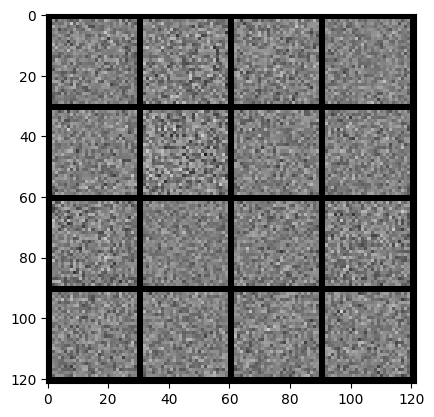

In [ ]:
x,y=next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

In [ ]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   pred = disc(fake)
   targets=torch.ones_like(pred)
   gen_loss=loss_func(pred,targets)

   return gen_loss


def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   disc_fake = disc(fake.detach())
   disc_fake_targets=torch.zeros_like(disc_fake)
   disc_fake_loss=loss_func(disc_fake, disc_fake_targets)

   disc_real = disc(real)
   disc_real_targets=torch.ones_like(disc_real)
   disc_real_loss=loss_func(disc_real, disc_real_targets)

   disc_loss=(disc_fake_loss+disc_real_loss)/2

   return disc_loss




  0%|          | 0/469 [00:00<?, ?it/s]

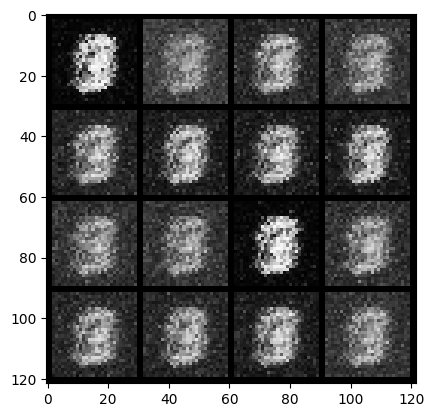

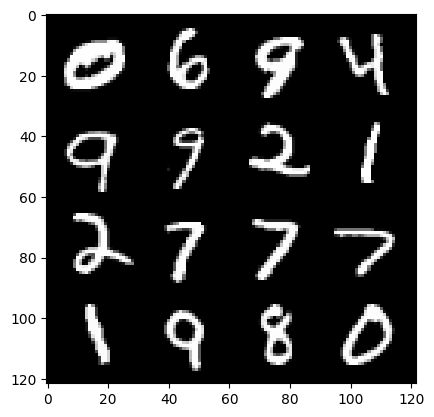

0: step 300 / Gen loss: 1.9397781201203672 / disc_loss: 0.33795970911780965


  0%|          | 0/469 [00:00<?, ?it/s]

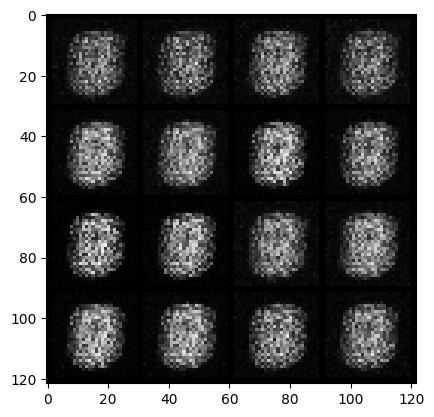

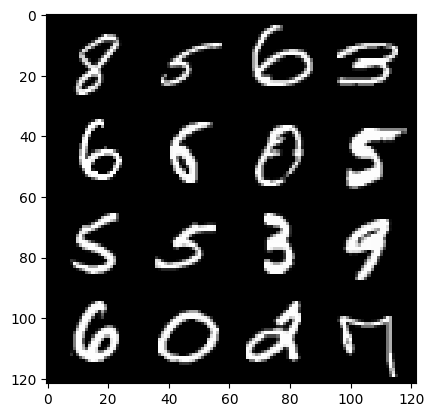

1: step 600 / Gen loss: 3.4339690367380795 / disc_loss: 0.12283512152731427


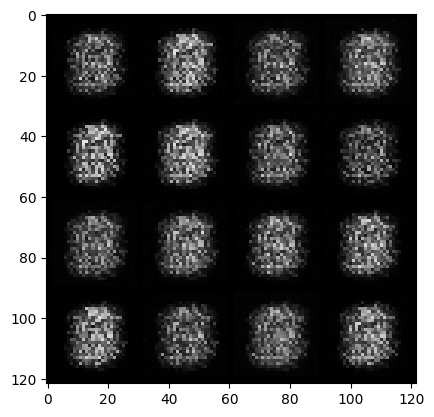

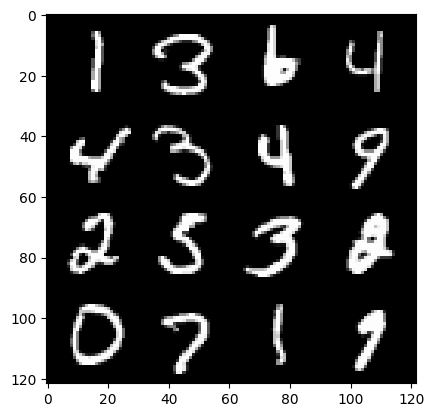

1: step 900 / Gen loss: 3.3020290732383724 / disc_loss: 0.0627108863616983


  0%|          | 0/469 [00:00<?, ?it/s]

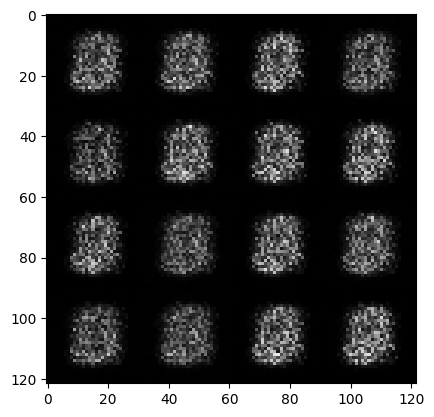

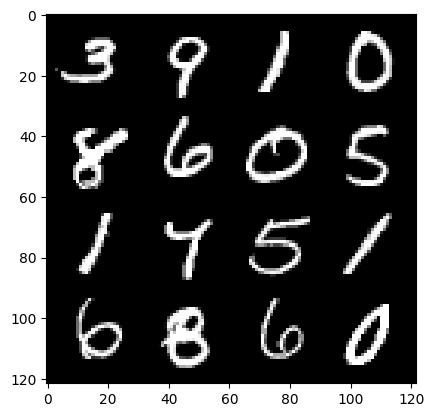

2: step 1200 / Gen loss: 3.283501981894175 / disc_loss: 0.046291264891624474


  0%|          | 0/469 [00:00<?, ?it/s]

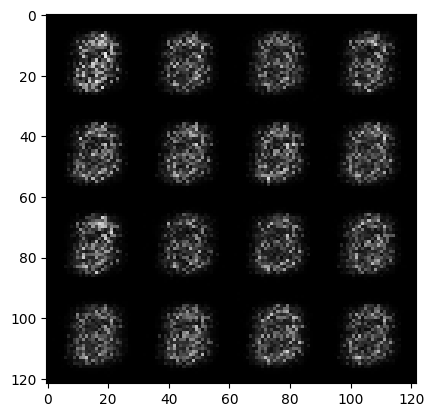

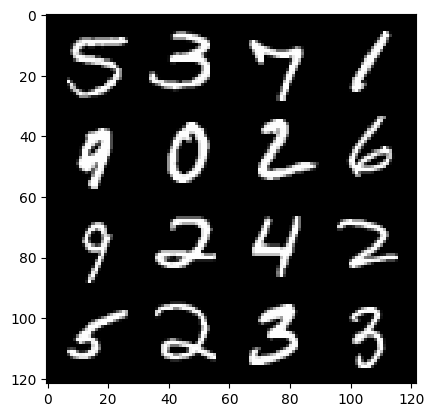

3: step 1500 / Gen loss: 3.435434446334841 / disc_loss: 0.03833491830776136


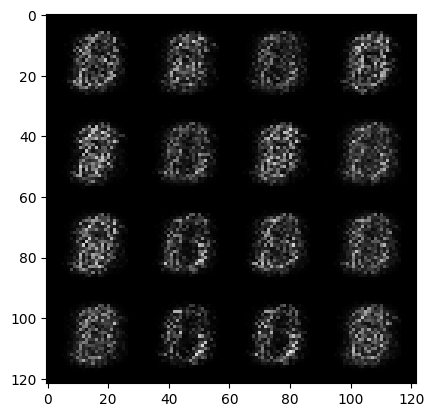

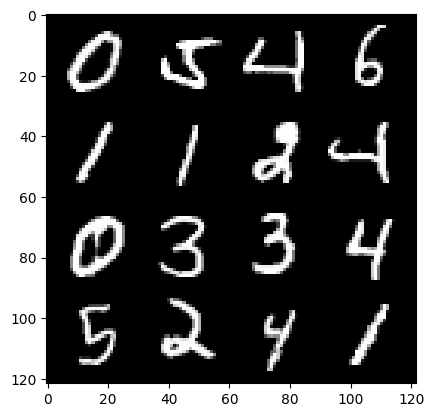

3: step 1800 / Gen loss: 3.4978140870730074 / disc_loss: 0.039343728236854066


  0%|          | 0/469 [00:00<?, ?it/s]

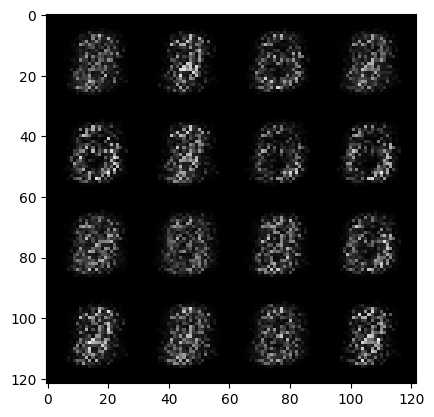

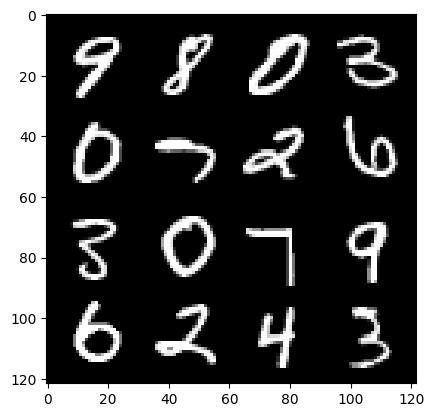

4: step 2100 / Gen loss: 3.8188079492251075 / disc_loss: 0.034455023047824725


  0%|          | 0/469 [00:00<?, ?it/s]

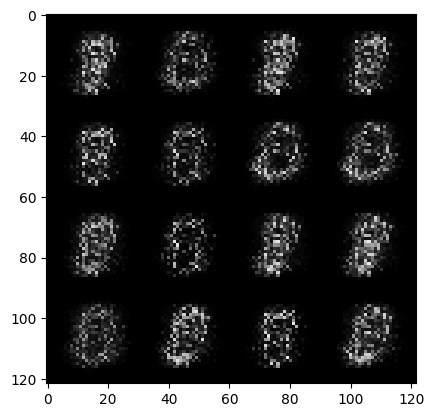

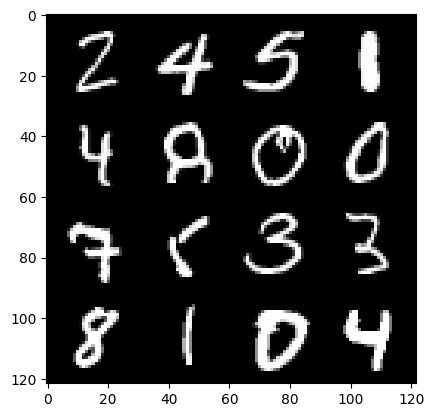

5: step 2400 / Gen loss: 4.116970029671985 / disc_loss: 0.02917280455430347


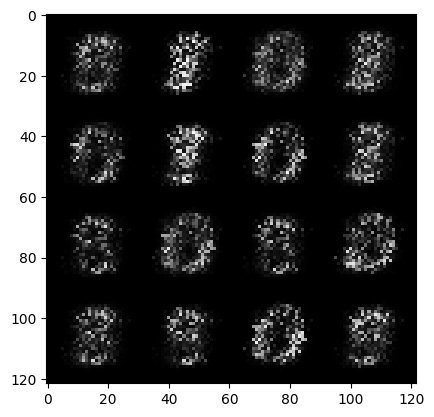

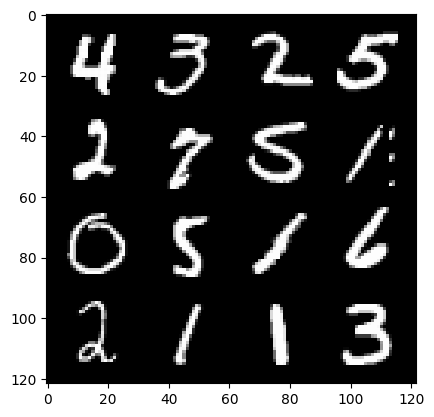

5: step 2700 / Gen loss: 4.566699309349062 / disc_loss: 0.02220903880273303


  0%|          | 0/469 [00:00<?, ?it/s]

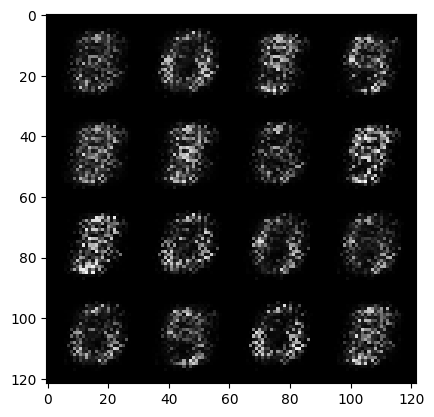

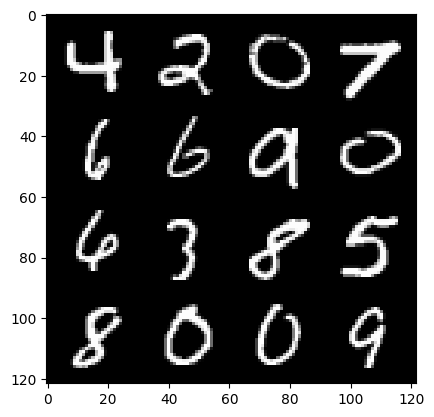

6: step 3000 / Gen loss: 4.861376819610595 / disc_loss: 0.02063334272863964


  0%|          | 0/469 [00:00<?, ?it/s]

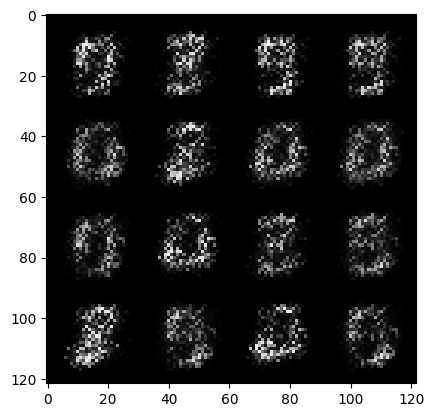

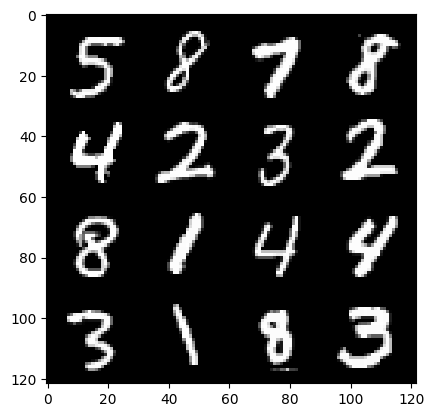

7: step 3300 / Gen loss: 5.1345930115381915 / disc_loss: 0.019484479759509357


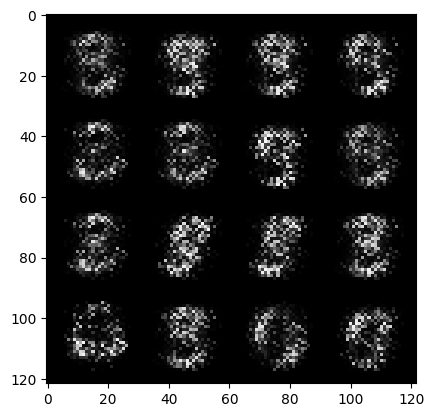

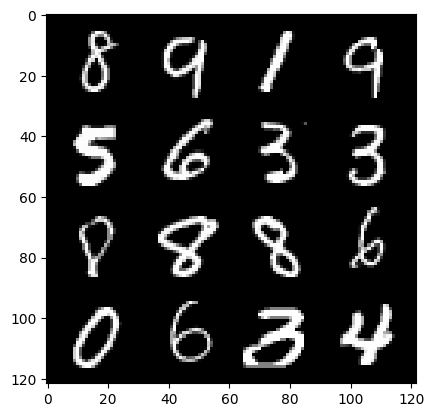

7: step 3600 / Gen loss: 5.304692029953004 / disc_loss: 0.018401585835963498


  0%|          | 0/469 [00:00<?, ?it/s]

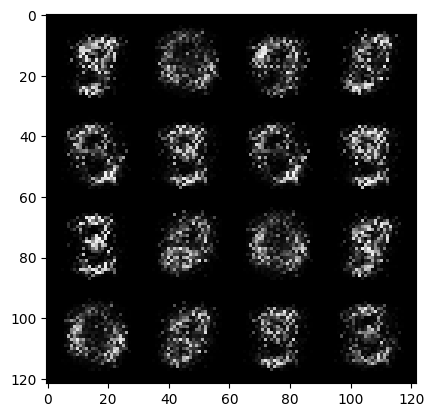

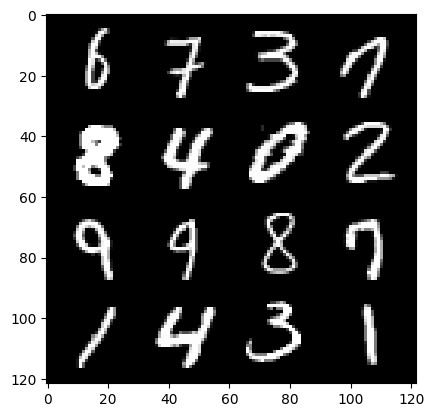

8: step 3900 / Gen loss: 5.538307890892034 / disc_loss: 0.017783315192597616


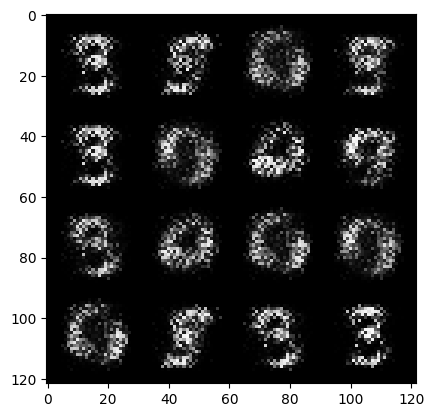

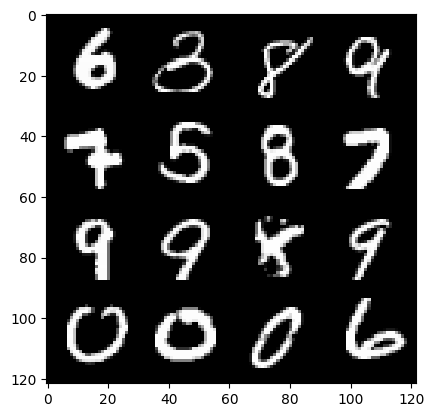

8: step 4200 / Gen loss: 5.586167006492612 / disc_loss: 0.01905474938917907


  0%|          | 0/469 [00:00<?, ?it/s]

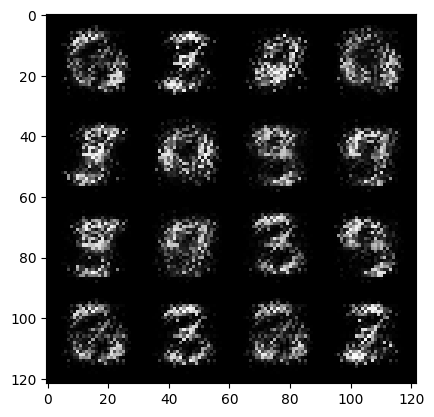

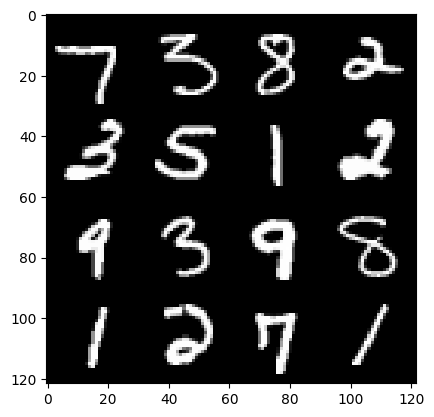

9: step 4500 / Gen loss: 5.842703967094419 / disc_loss: 0.019446123524879427


  0%|          | 0/469 [00:00<?, ?it/s]

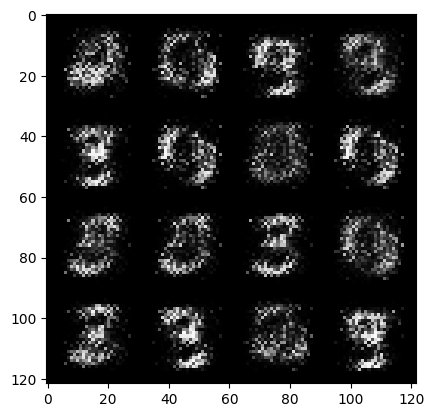

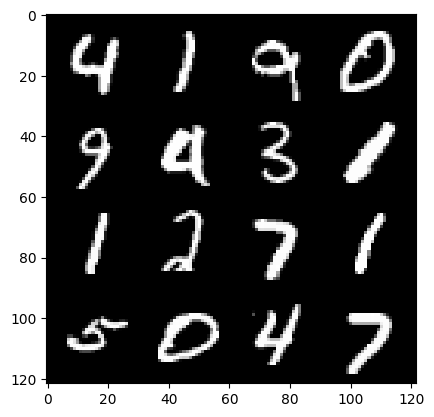

10: step 4800 / Gen loss: 6.379436969757081 / disc_loss: 0.01693988645449281


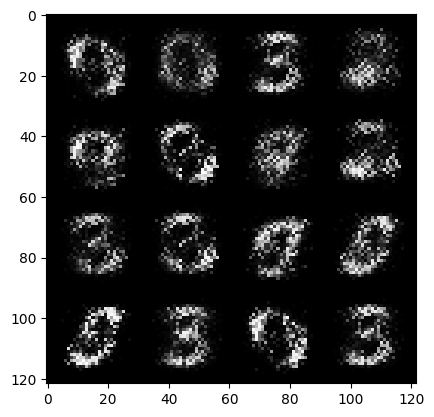

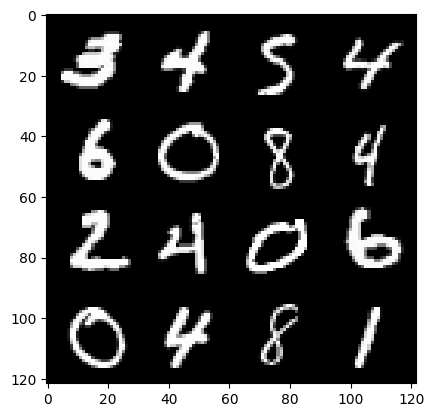

10: step 5100 / Gen loss: 6.701553090413419 / disc_loss: 0.01661704330549886


  0%|          | 0/469 [00:00<?, ?it/s]

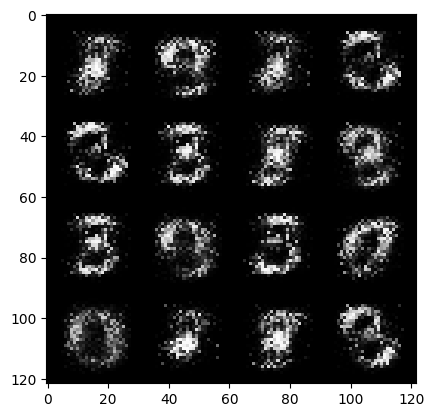

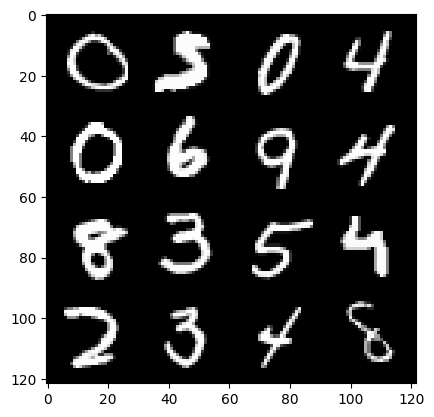

11: step 5400 / Gen loss: 6.762508454322814 / disc_loss: 0.014297961539899309


  0%|          | 0/469 [00:00<?, ?it/s]

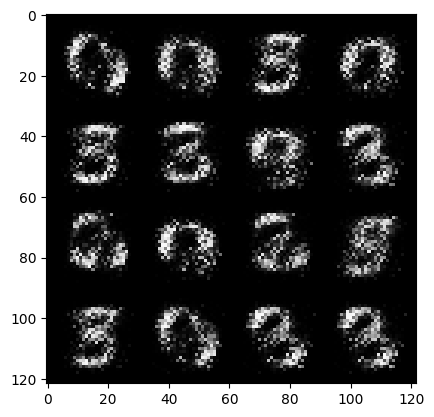

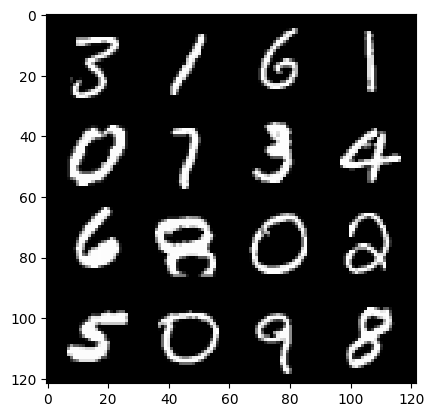

12: step 5700 / Gen loss: 6.56703492005666 / disc_loss: 0.016294302283786238


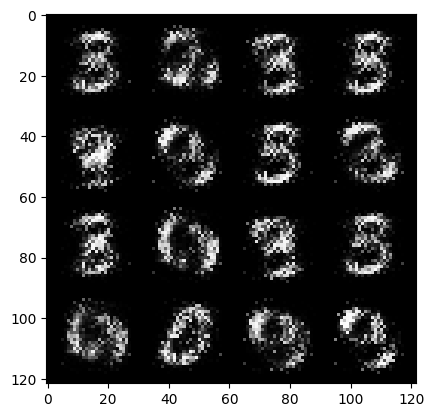

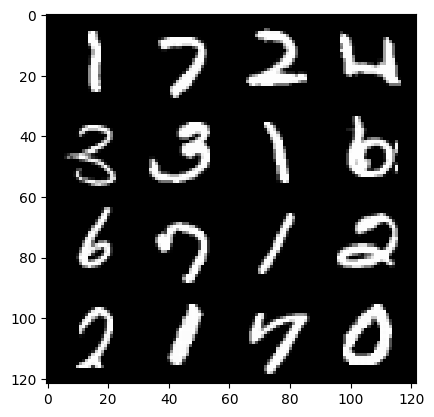

12: step 6000 / Gen loss: 6.347107780774435 / disc_loss: 0.0133519781435219


  0%|          | 0/469 [00:00<?, ?it/s]

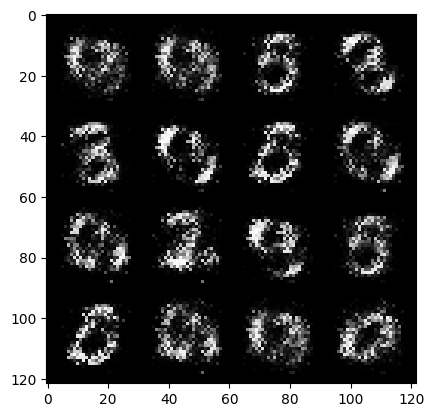

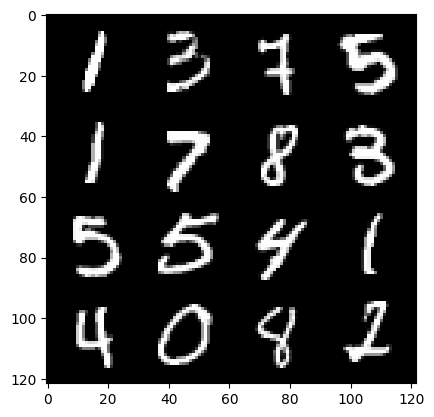

13: step 6300 / Gen loss: 6.616957408587131 / disc_loss: 0.010545369863975789


  0%|          | 0/469 [00:00<?, ?it/s]

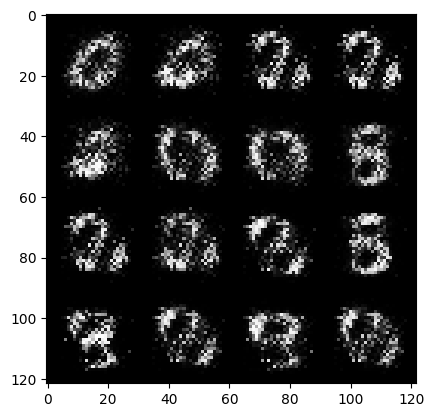

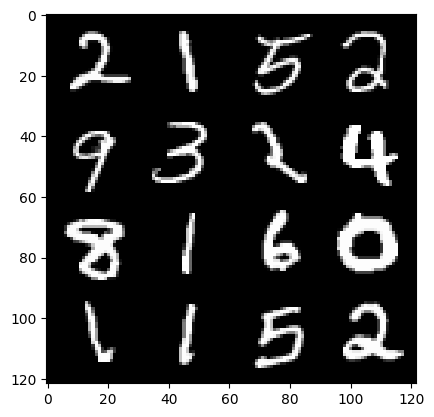

14: step 6600 / Gen loss: 6.375590542157489 / disc_loss: 0.009728581795158484


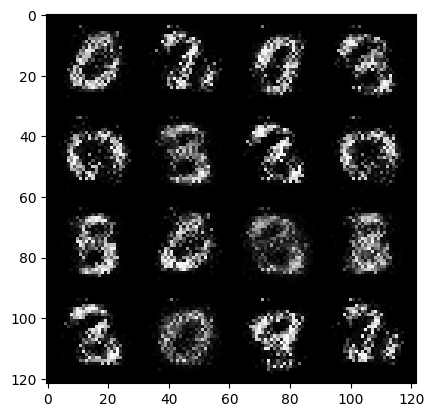

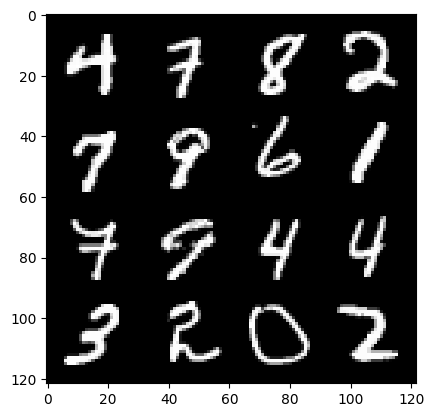

14: step 6900 / Gen loss: 6.70381876627604 / disc_loss: 0.009868266702008743


  0%|          | 0/469 [00:00<?, ?it/s]

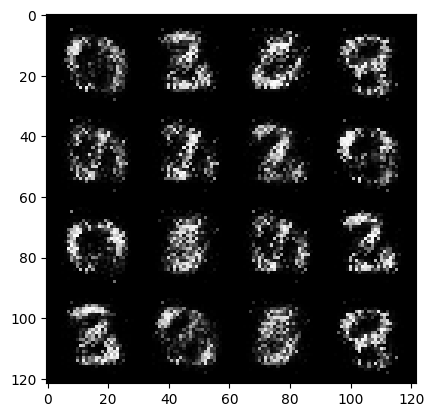

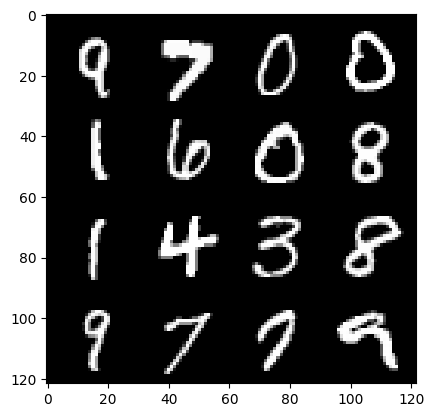

15: step 7200 / Gen loss: 7.237856497764589 / disc_loss: 0.01098823537662004


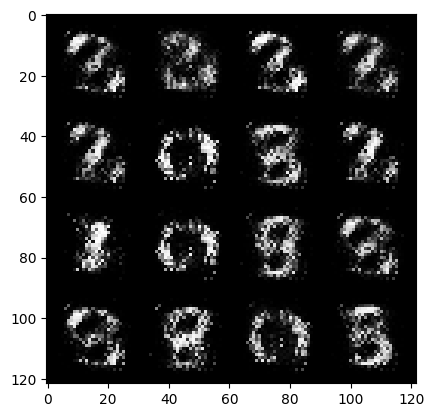

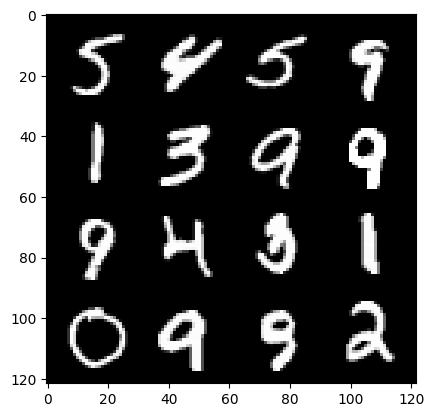

15: step 7500 / Gen loss: 6.918175150553389 / disc_loss: 0.013801121662836532


  0%|          | 0/469 [00:00<?, ?it/s]

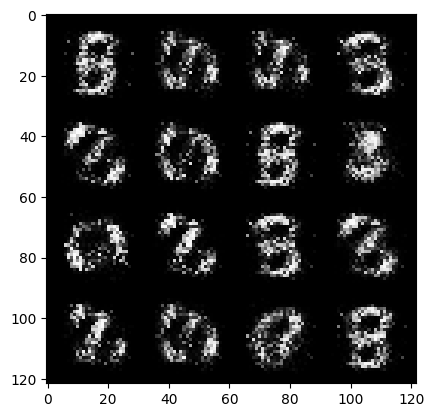

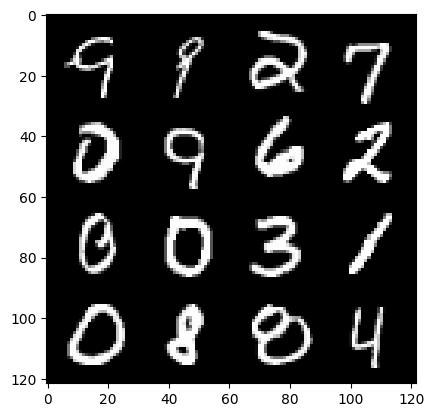

16: step 7800 / Gen loss: 6.706252638498944 / disc_loss: 0.013551575116968403


  0%|          | 0/469 [00:00<?, ?it/s]

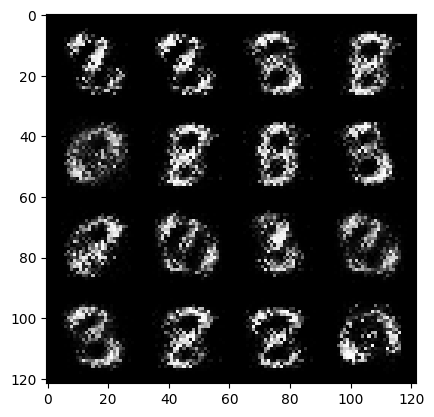

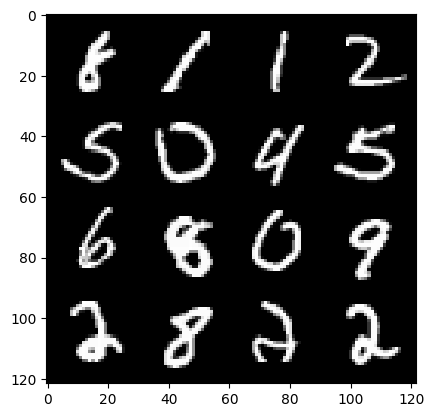

17: step 8100 / Gen loss: 6.720753122965496 / disc_loss: 0.012024633044687417


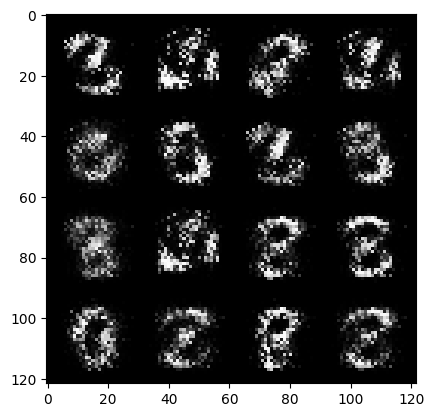

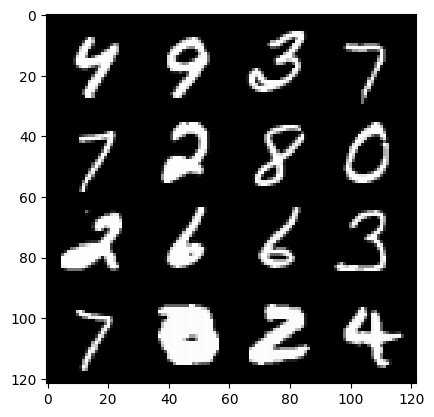

17: step 8400 / Gen loss: 7.124262776374824 / disc_loss: 0.010583659962285313


  0%|          | 0/469 [00:00<?, ?it/s]

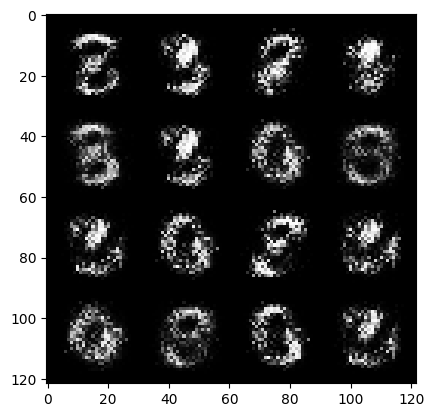

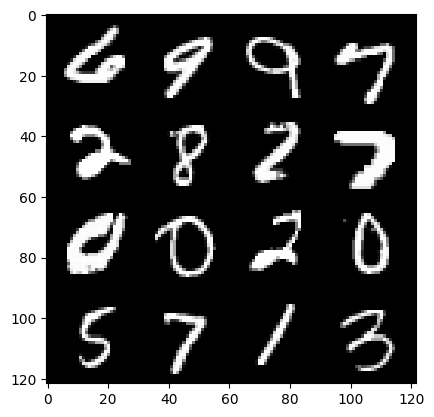

18: step 8700 / Gen loss: 7.054078545570377 / disc_loss: 0.011426381114094214


  0%|          | 0/469 [00:00<?, ?it/s]

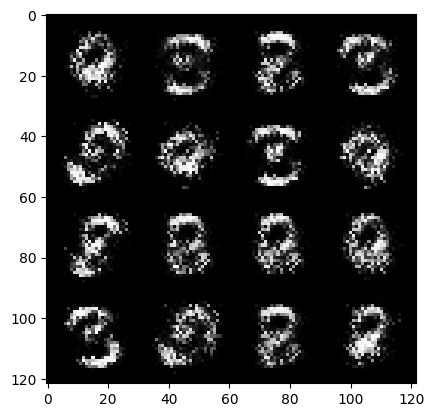

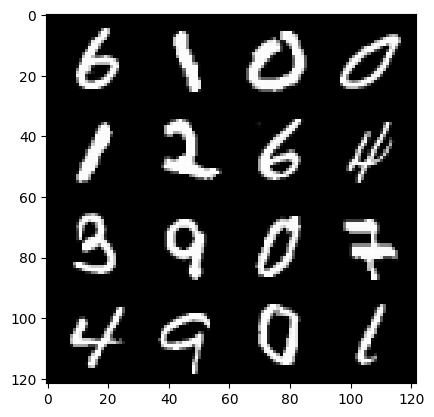

19: step 9000 / Gen loss: 6.777101947466532 / disc_loss: 0.01160495278425515


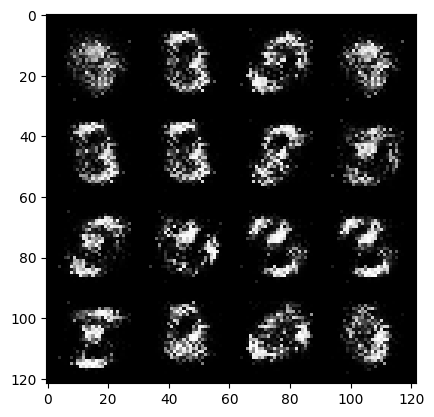

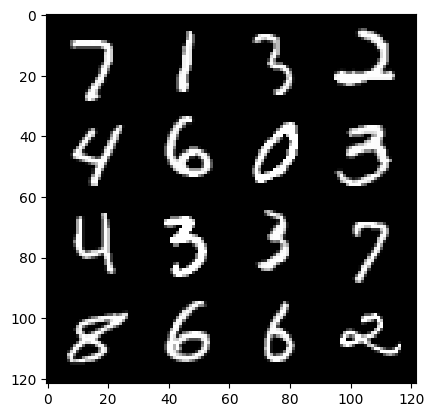

19: step 9300 / Gen loss: 6.850070729255675 / disc_loss: 0.011263569115350645


  0%|          | 0/469 [00:00<?, ?it/s]

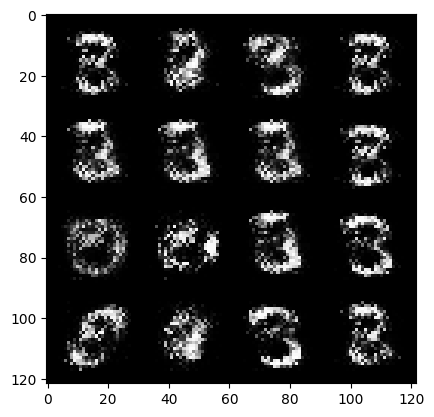

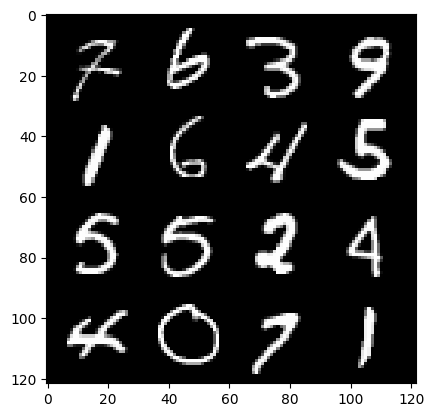

20: step 9600 / Gen loss: 6.89981330553691 / disc_loss: 0.010941176553412018


  0%|          | 0/469 [00:00<?, ?it/s]

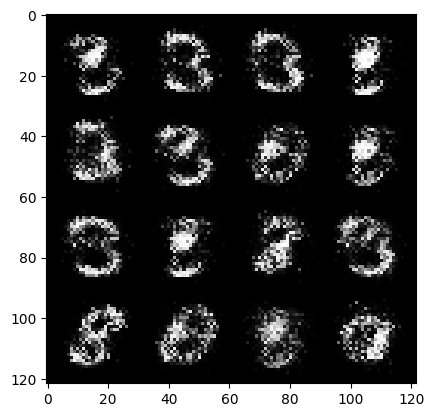

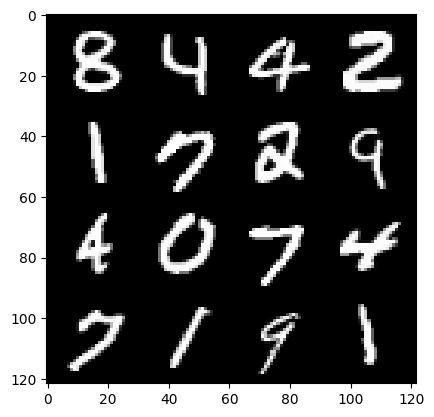

21: step 9900 / Gen loss: 6.946058216094972 / disc_loss: 0.010554782900338379


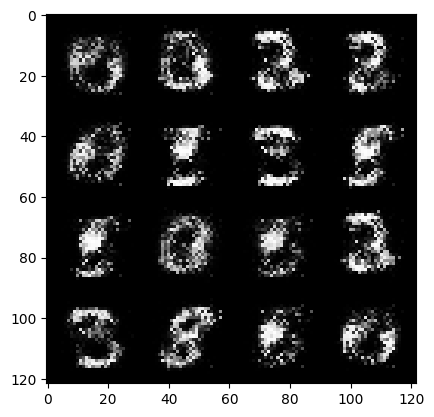

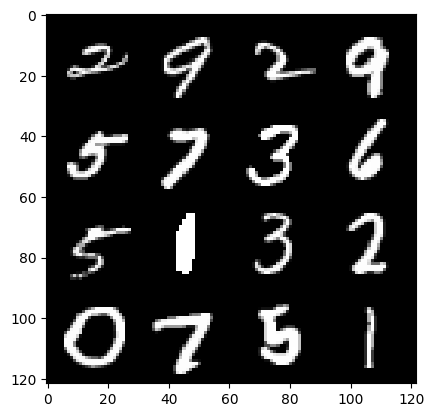

21: step 10200 / Gen loss: 7.05890182654063 / disc_loss: 0.010271210995269937


  0%|          | 0/469 [00:00<?, ?it/s]

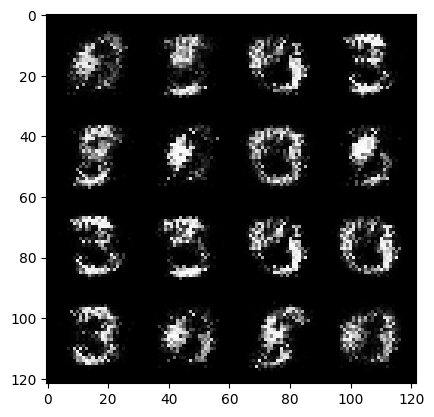

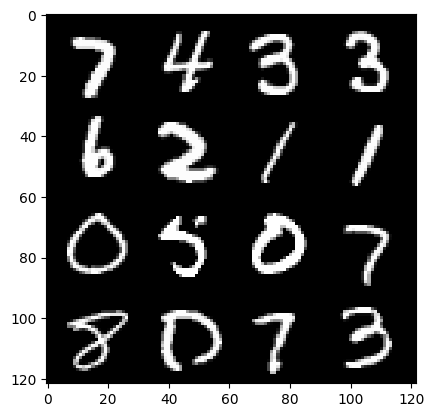

22: step 10500 / Gen loss: 6.952178452809651 / disc_loss: 0.010507264797342935


  0%|          | 0/469 [00:00<?, ?it/s]

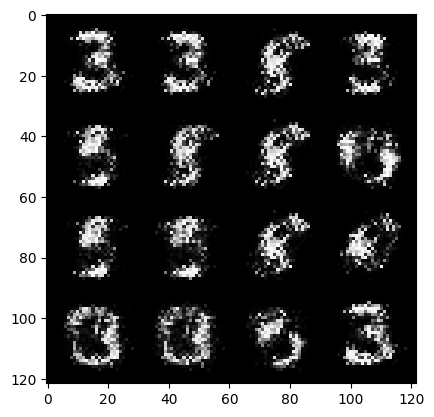

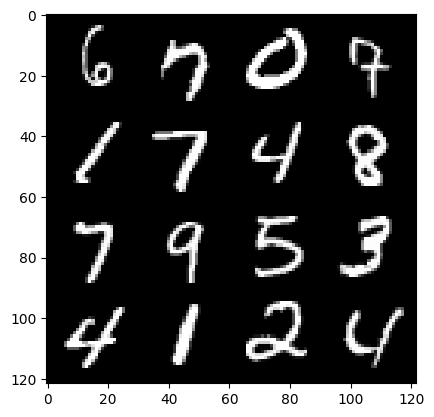

23: step 10800 / Gen loss: 6.7829405037562 / disc_loss: 0.012232738626577588


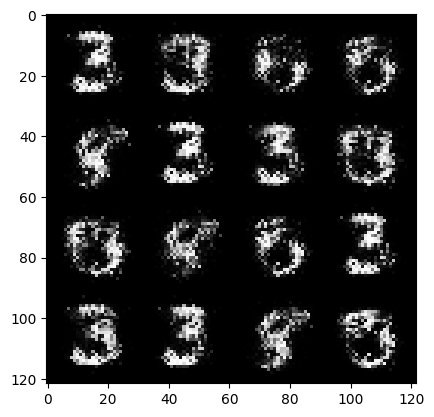

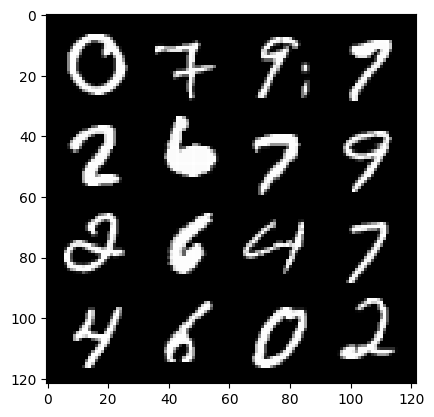

23: step 11100 / Gen loss: 6.813315436045332 / disc_loss: 0.010738698924736435


  0%|          | 0/469 [00:00<?, ?it/s]

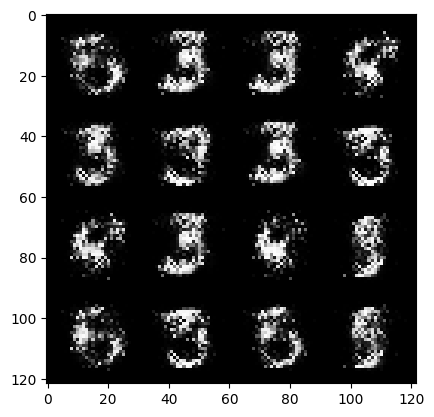

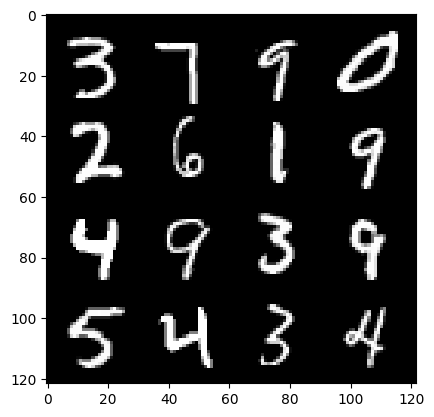

24: step 11400 / Gen loss: 6.93044960816701 / disc_loss: 0.010498988626835258


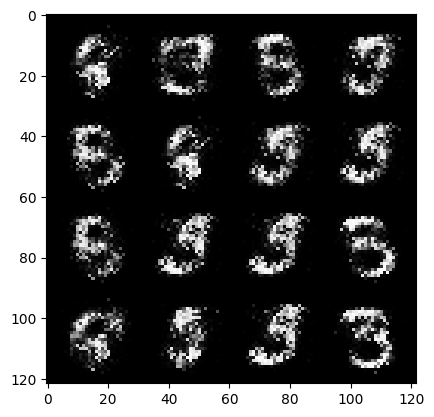

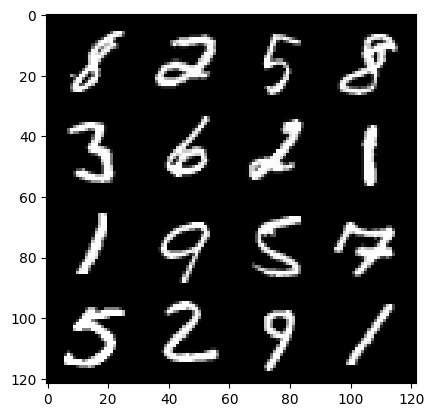

24: step 11700 / Gen loss: 7.317802284558617 / disc_loss: 0.009825319046697884


  0%|          | 0/469 [00:00<?, ?it/s]

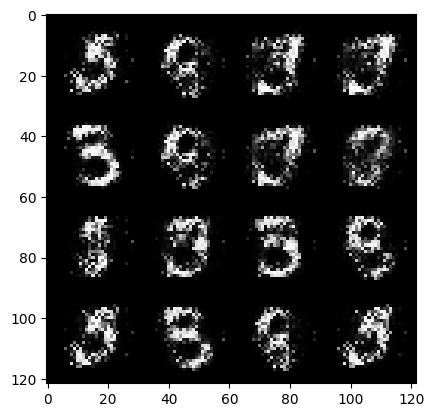

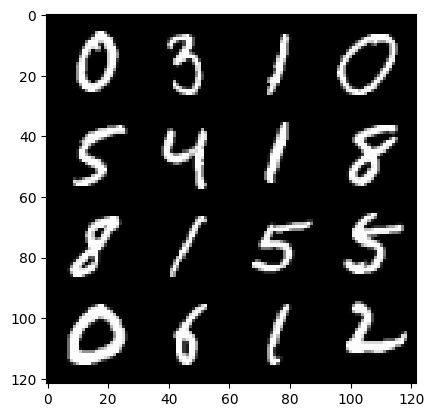

25: step 12000 / Gen loss: 7.207402882575995 / disc_loss: 0.010081250061824304


  0%|          | 0/469 [00:00<?, ?it/s]

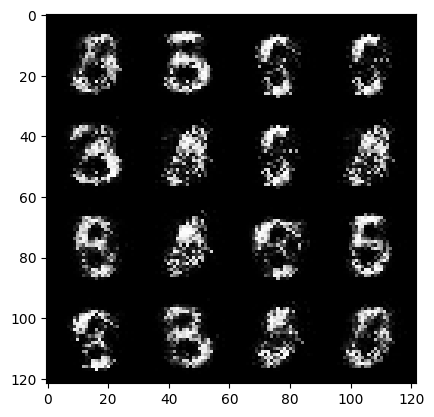

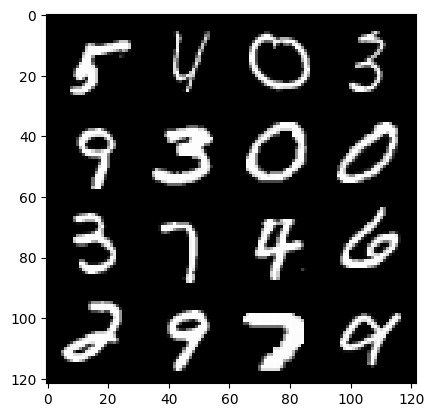

26: step 12300 / Gen loss: 7.0323593393961605 / disc_loss: 0.012342040371537832


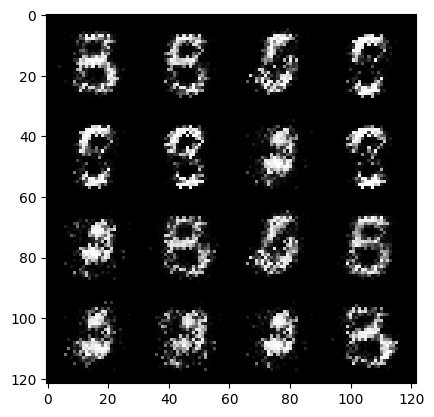

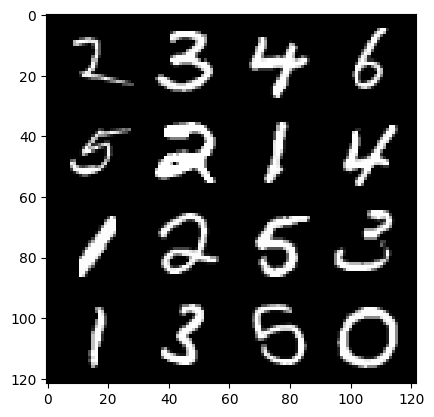

26: step 12600 / Gen loss: 6.90839515686035 / disc_loss: 0.013021218181820586


  0%|          | 0/469 [00:00<?, ?it/s]

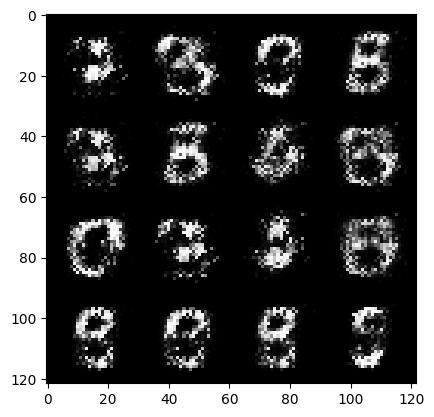

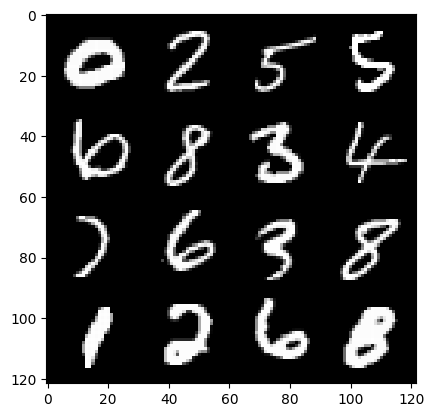

27: step 12900 / Gen loss: 6.950704859097803 / disc_loss: 0.013143247448606418


  0%|          | 0/469 [00:00<?, ?it/s]

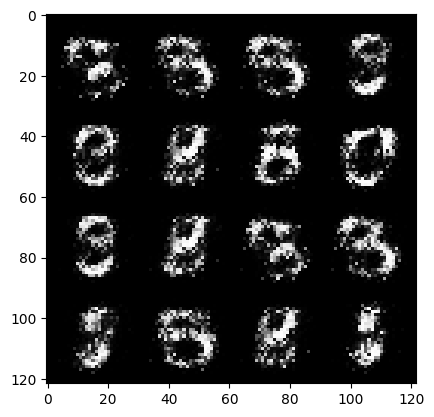

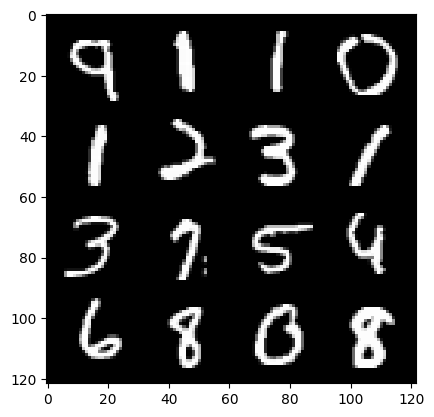

28: step 13200 / Gen loss: 7.080844621658332 / disc_loss: 0.013533303962709993


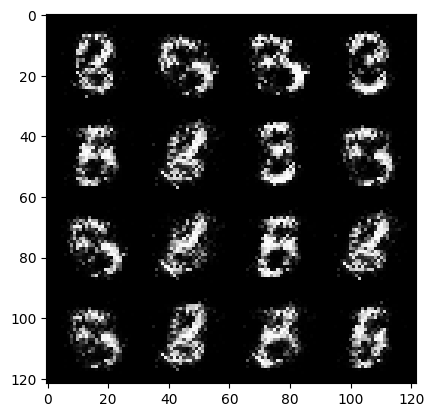

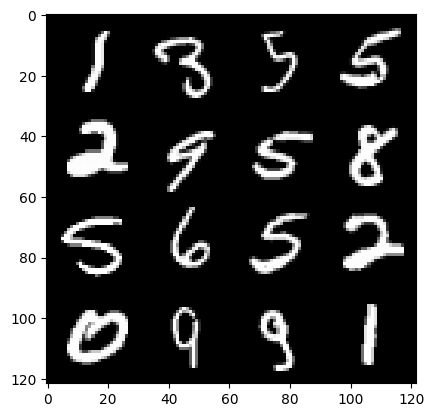

28: step 13500 / Gen loss: 7.158783391316732 / disc_loss: 0.014350638820324108


  0%|          | 0/469 [00:00<?, ?it/s]

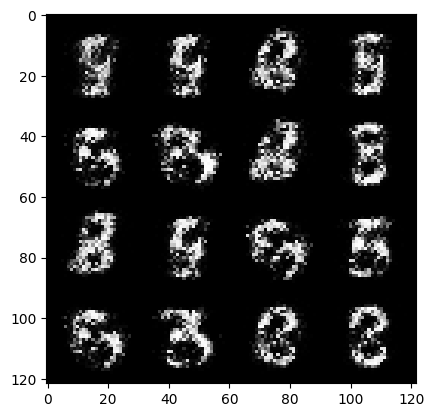

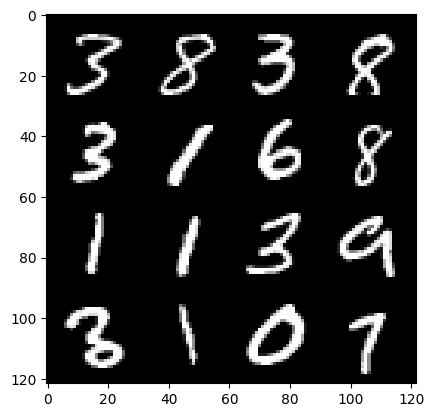

29: step 13800 / Gen loss: 6.87071525255839 / disc_loss: 0.015472480810713033


  0%|          | 0/469 [00:00<?, ?it/s]

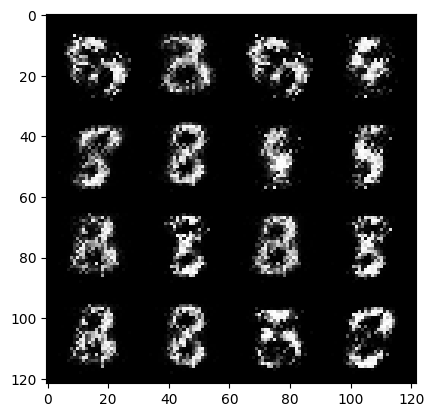

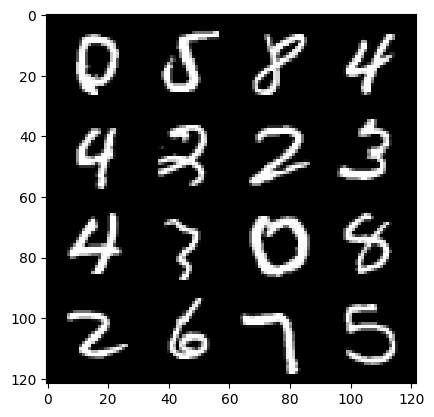

30: step 14100 / Gen loss: 6.863850541114809 / disc_loss: 0.013857437456026665


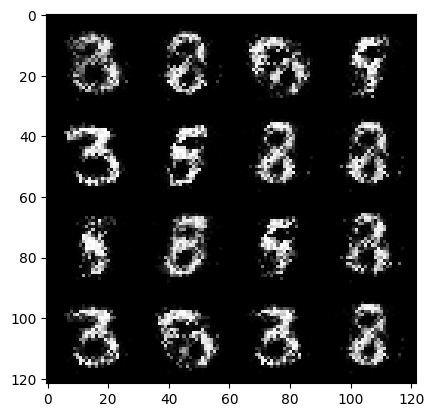

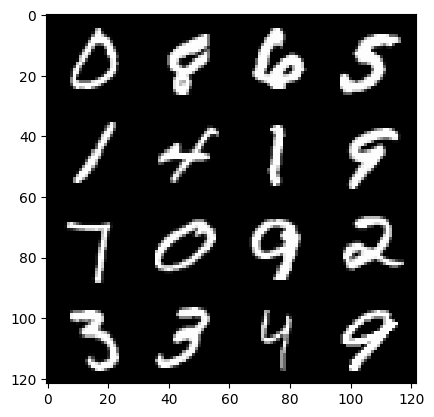

30: step 14400 / Gen loss: 6.703704201380409 / disc_loss: 0.014704454948659983


  0%|          | 0/469 [00:00<?, ?it/s]

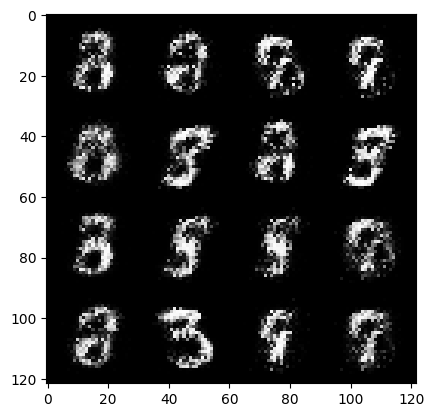

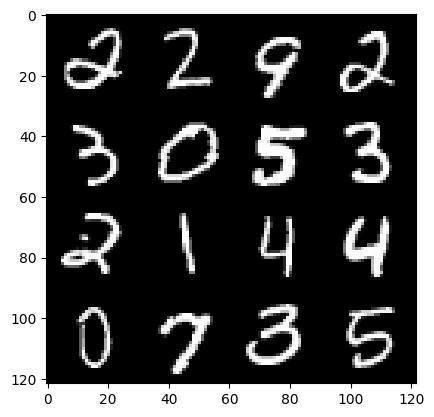

31: step 14700 / Gen loss: 7.025213718414307 / disc_loss: 0.01642843202765409


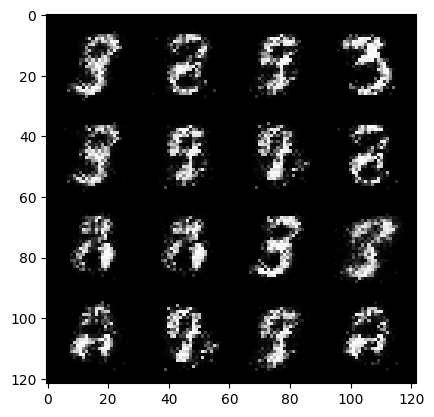

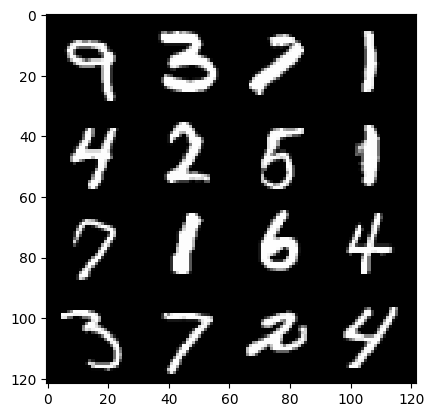

31: step 15000 / Gen loss: 6.395996748606365 / disc_loss: 0.02060248495855681


  0%|          | 0/469 [00:00<?, ?it/s]

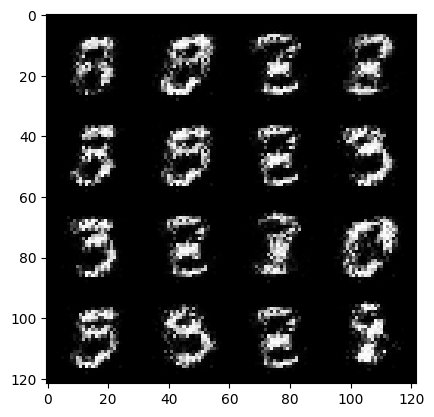

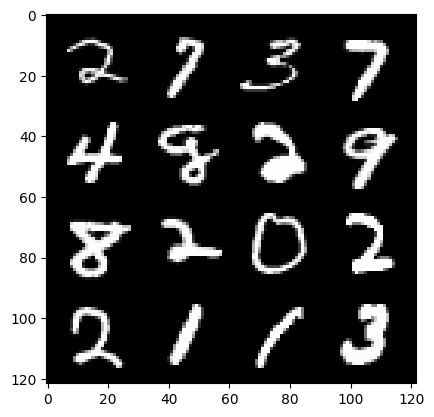

32: step 15300 / Gen loss: 5.998855058352152 / disc_loss: 0.02604468282467377


  0%|          | 0/469 [00:00<?, ?it/s]

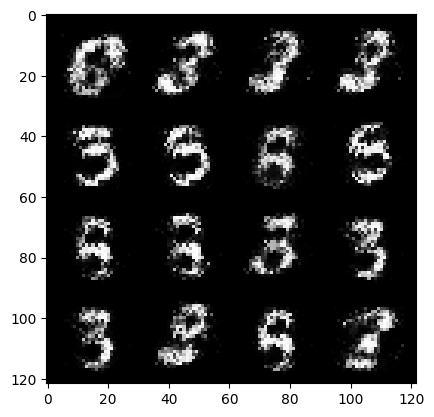

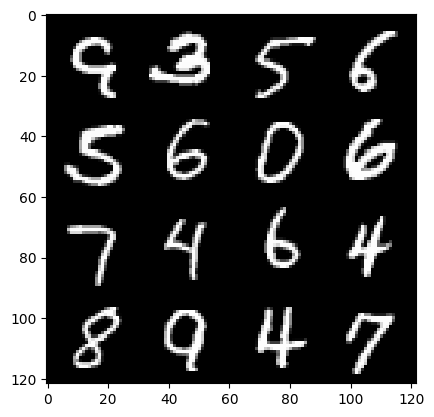

33: step 15600 / Gen loss: 6.309588513374325 / disc_loss: 0.022808832107887898


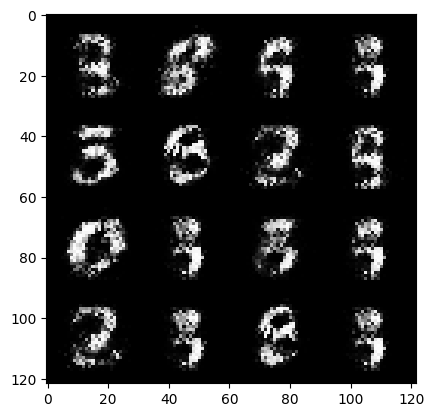

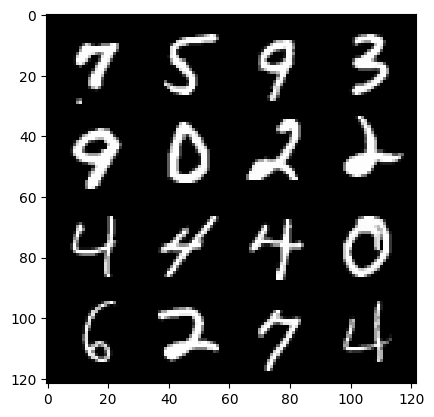

33: step 15900 / Gen loss: 6.382336068153385 / disc_loss: 0.018725502054827908


  0%|          | 0/469 [00:00<?, ?it/s]

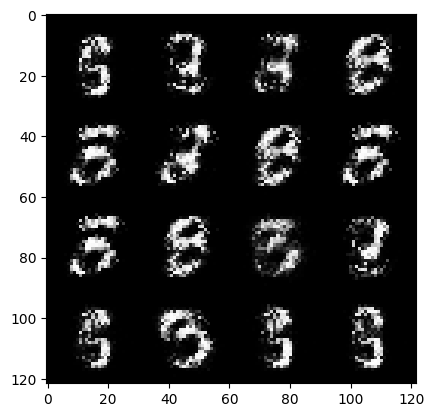

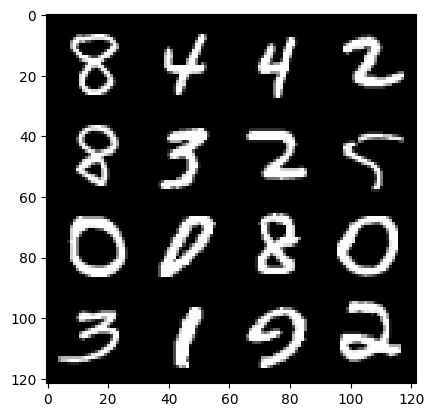

34: step 16200 / Gen loss: 6.238842296600338 / disc_loss: 0.016387901534326364


  0%|          | 0/469 [00:00<?, ?it/s]

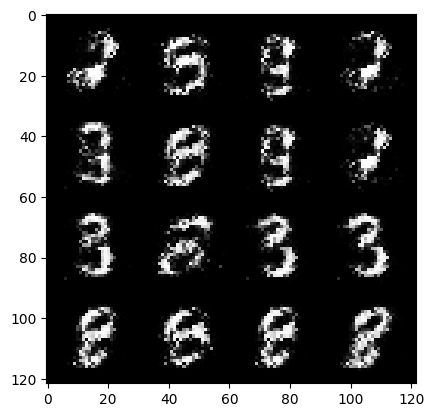

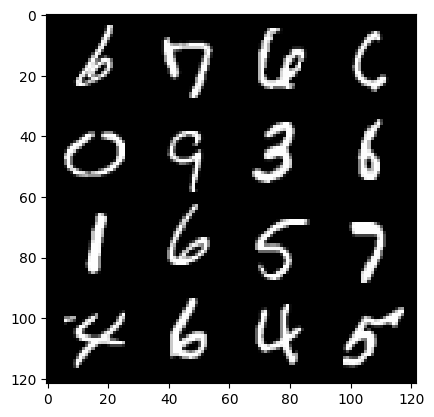

35: step 16500 / Gen loss: 6.377675123214719 / disc_loss: 0.017418732305523016


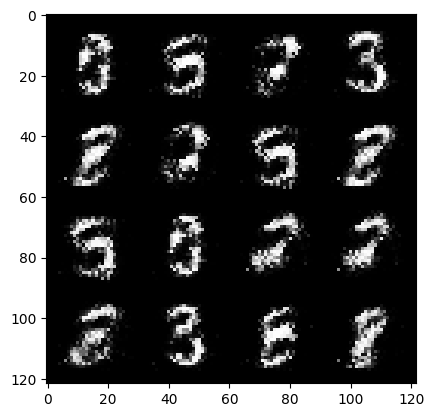

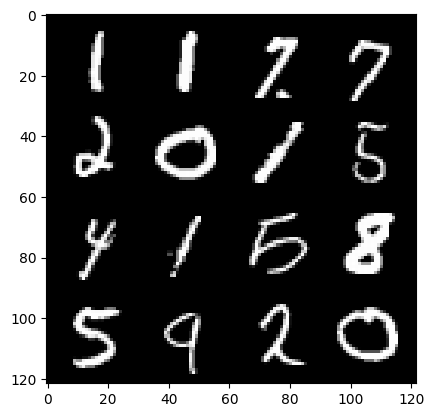

35: step 16800 / Gen loss: 6.483958091735839 / disc_loss: 0.021258475569387265


  0%|          | 0/469 [00:00<?, ?it/s]

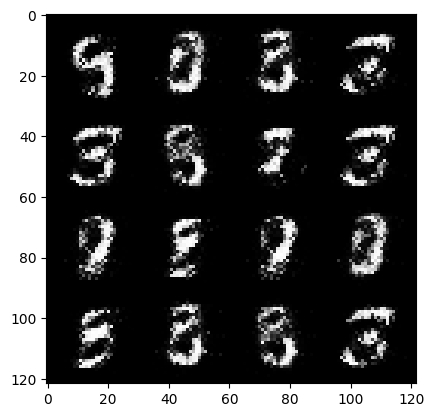

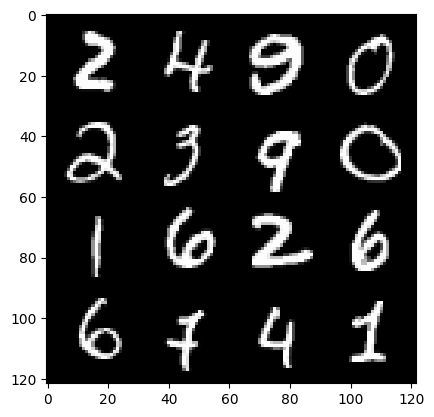

36: step 17100 / Gen loss: 6.351940356890363 / disc_loss: 0.021176250685627236


  0%|          | 0/469 [00:00<?, ?it/s]

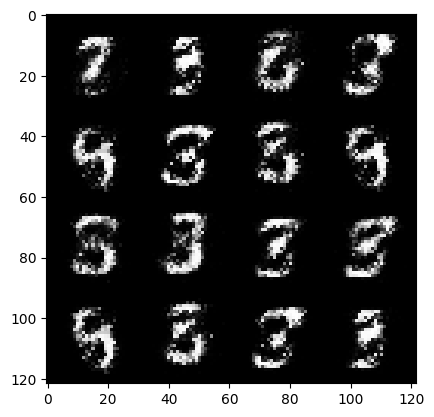

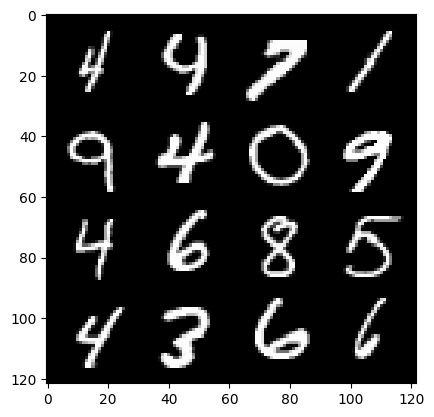

37: step 17400 / Gen loss: 6.592093825340269 / disc_loss: 0.02263762732812514


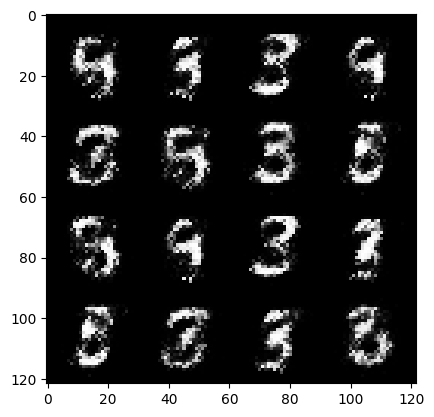

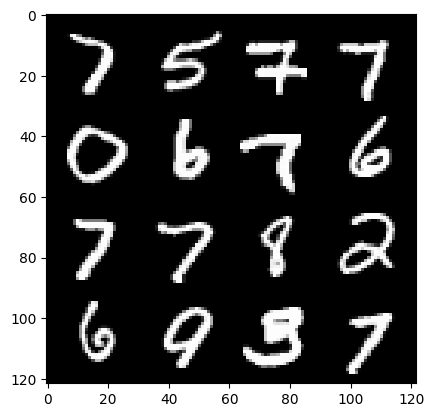

37: step 17700 / Gen loss: 6.679140241940819 / disc_loss: 0.023312015149276694


  0%|          | 0/469 [00:00<?, ?it/s]

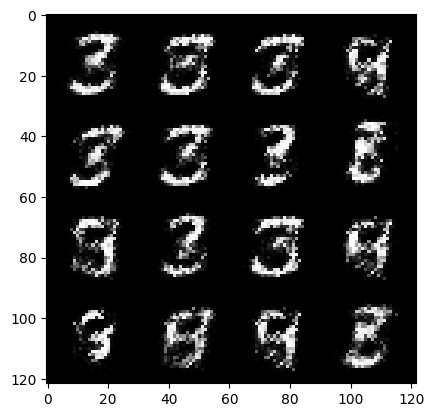

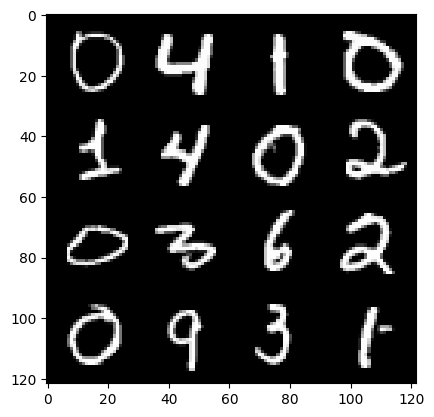

38: step 18000 / Gen loss: 6.4514884487787825 / disc_loss: 0.023088257516113424


  0%|          | 0/469 [00:00<?, ?it/s]

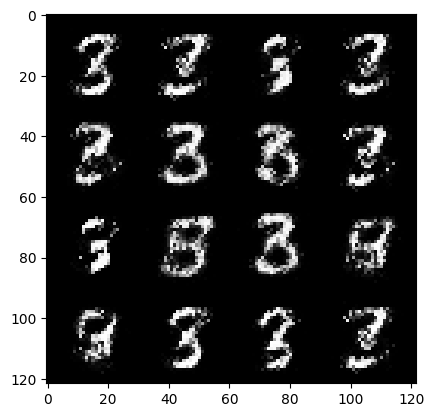

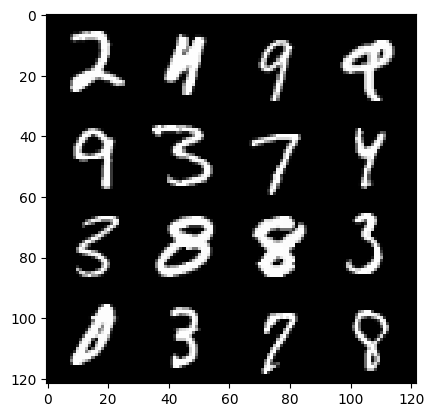

39: step 18300 / Gen loss: 6.100255250930786 / disc_loss: 0.0219039856013842


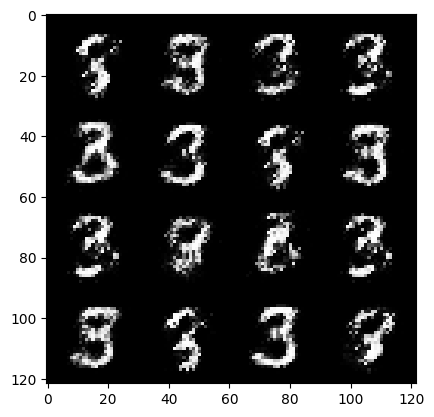

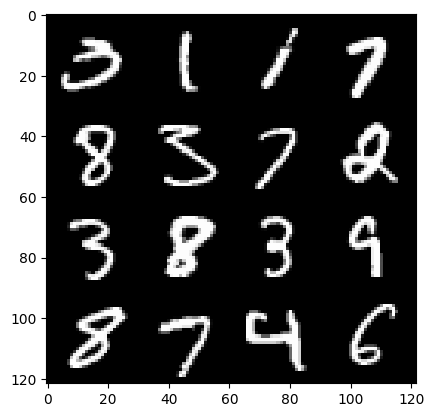

39: step 18600 / Gen loss: 6.427778910001123 / disc_loss: 0.021762852648583558


  0%|          | 0/469 [00:00<?, ?it/s]

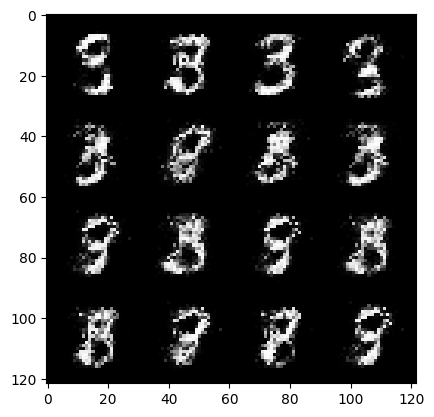

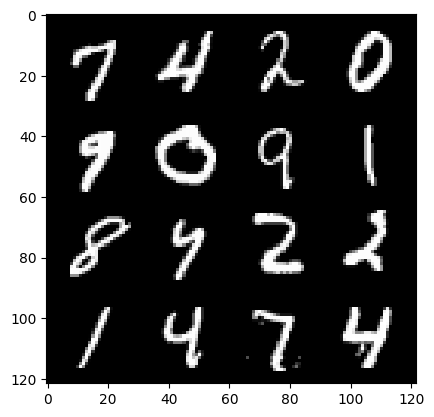

40: step 18900 / Gen loss: 6.2325600544611595 / disc_loss: 0.022944349987277134


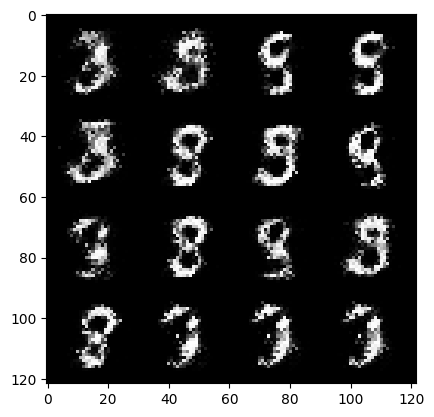

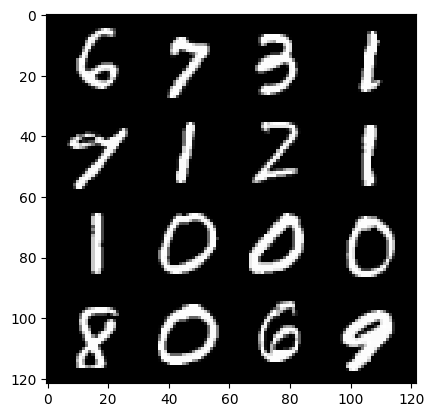

40: step 19200 / Gen loss: 5.997517334620151 / disc_loss: 0.03258750912422936


  0%|          | 0/469 [00:00<?, ?it/s]

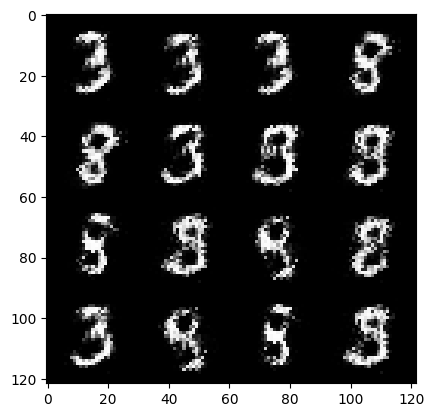

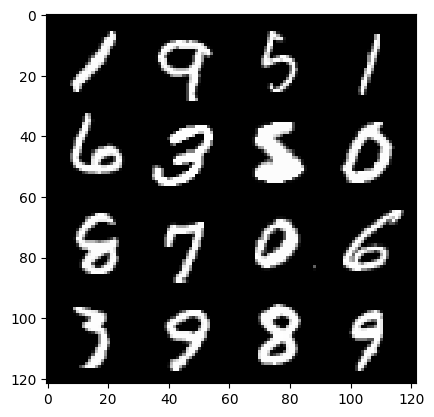

41: step 19500 / Gen loss: 5.949948943456014 / disc_loss: 0.03373535945080221


  0%|          | 0/469 [00:00<?, ?it/s]

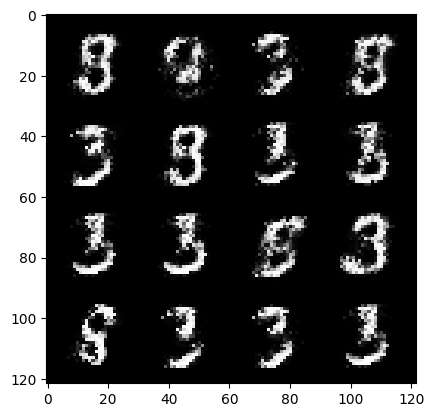

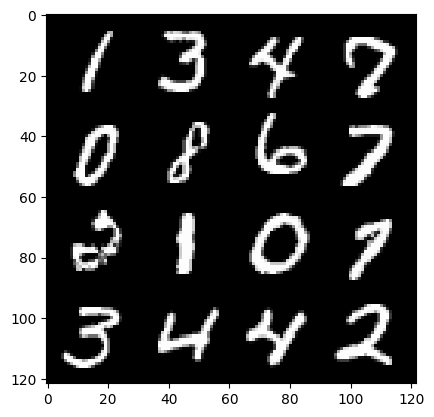

42: step 19800 / Gen loss: 5.757062258720392 / disc_loss: 0.034587065096323685


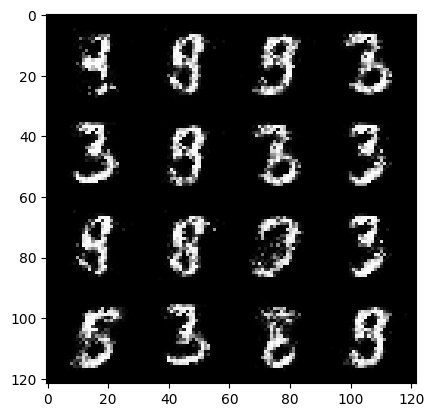

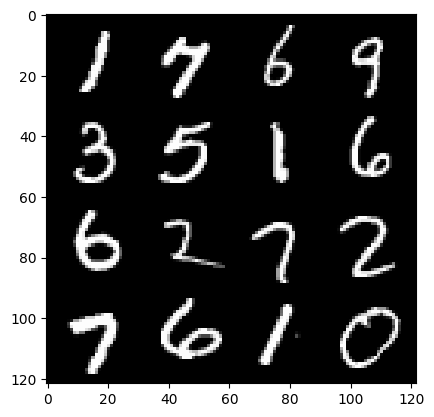

42: step 20100 / Gen loss: 5.813373735745747 / disc_loss: 0.03147461446778228


  0%|          | 0/469 [00:00<?, ?it/s]

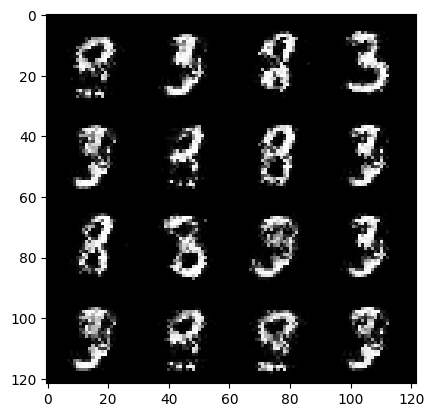

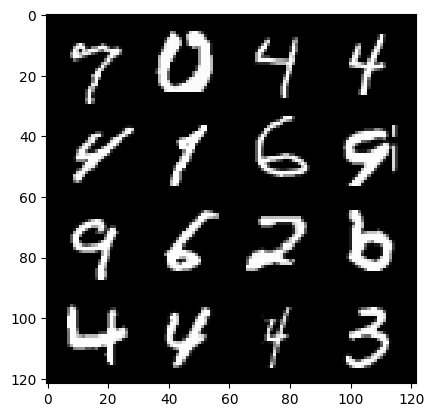

43: step 20400 / Gen loss: 5.812509351571399 / disc_loss: 0.028408264323758578


  0%|          | 0/469 [00:00<?, ?it/s]

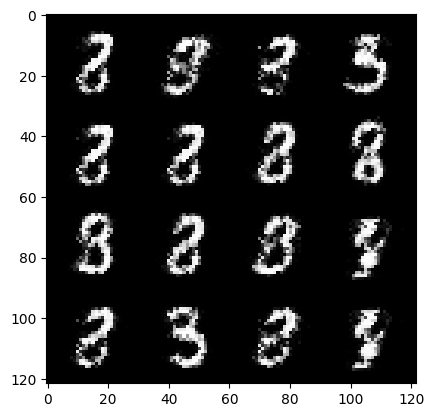

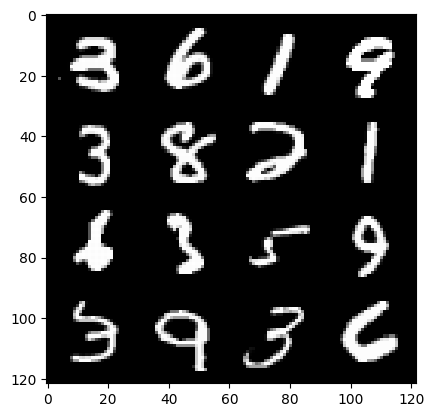

44: step 20700 / Gen loss: 5.511687552134199 / disc_loss: 0.03682814106189957


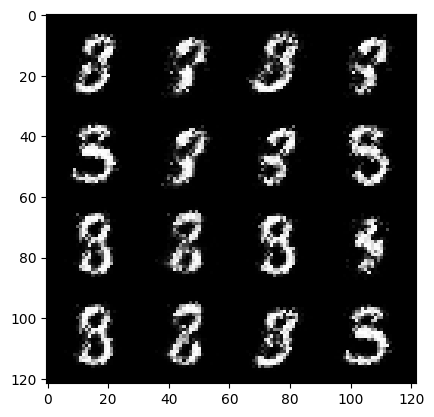

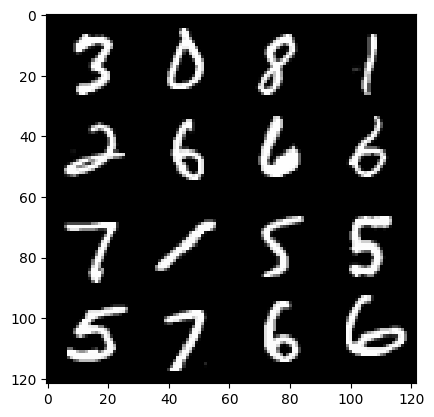

44: step 21000 / Gen loss: 5.403807317415871 / disc_loss: 0.03750211915311713


  0%|          | 0/469 [00:00<?, ?it/s]

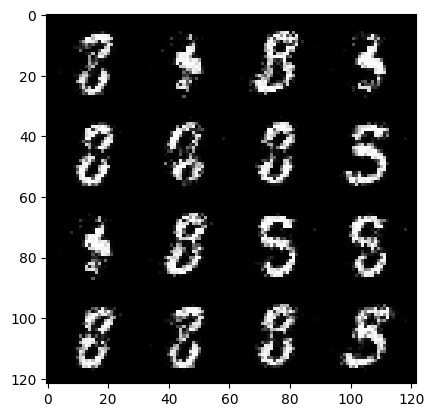

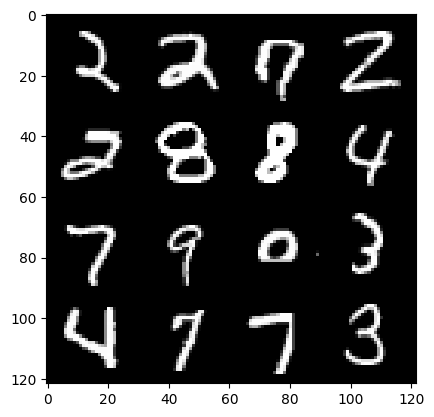

45: step 21300 / Gen loss: 5.600012474060054 / disc_loss: 0.03935972030429792


  0%|          | 0/469 [00:00<?, ?it/s]

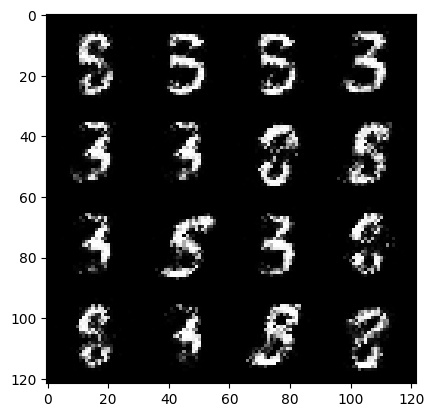

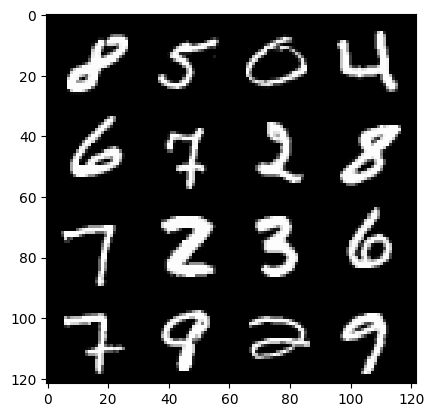

46: step 21600 / Gen loss: 5.9126121854782125 / disc_loss: 0.03559739759424701


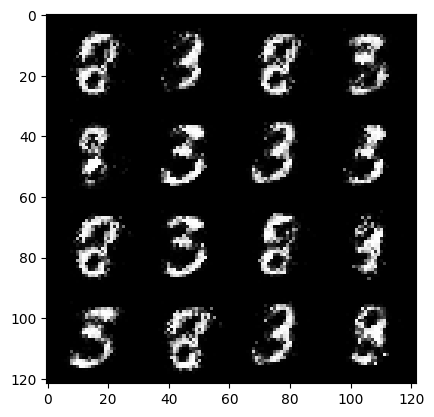

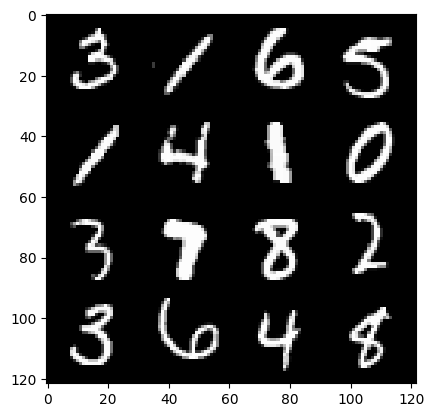

46: step 21900 / Gen loss: 5.97420902570089 / disc_loss: 0.03929428189061581


  0%|          | 0/469 [00:00<?, ?it/s]

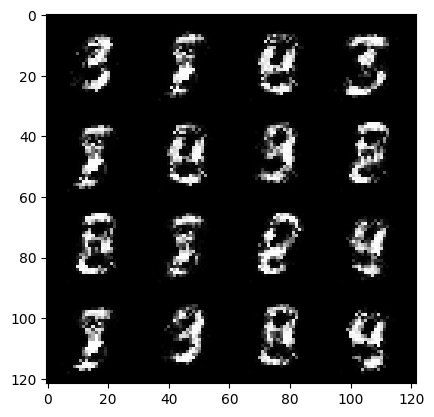

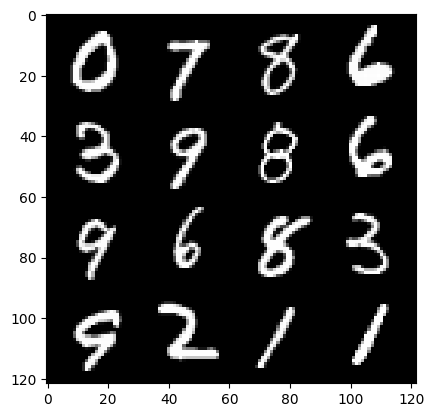

47: step 22200 / Gen loss: 5.771073657671606 / disc_loss: 0.04547161606916537


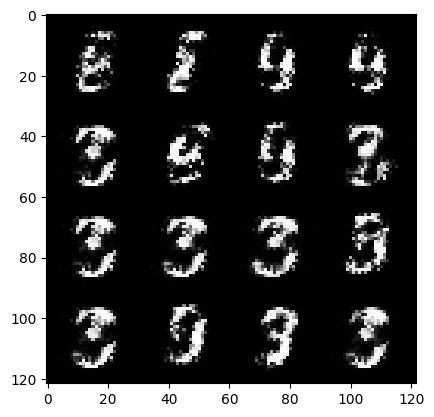

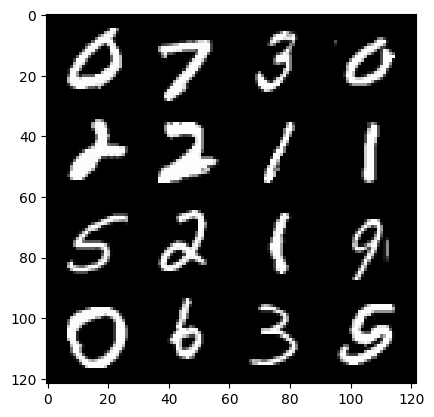

47: step 22500 / Gen loss: 5.706379395325976 / disc_loss: 0.047278152611106634


  0%|          | 0/469 [00:00<?, ?it/s]

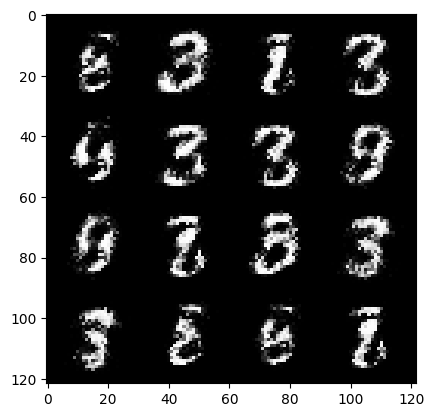

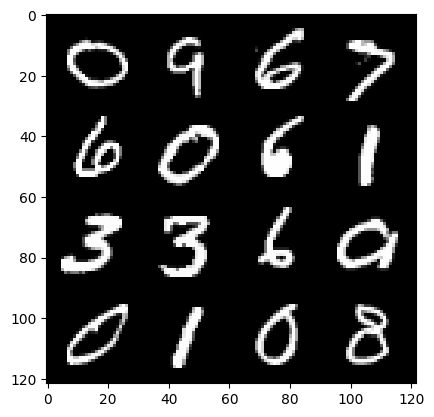

48: step 22800 / Gen loss: 6.032954750061032 / disc_loss: 0.04142358414518335


  0%|          | 0/469 [00:00<?, ?it/s]

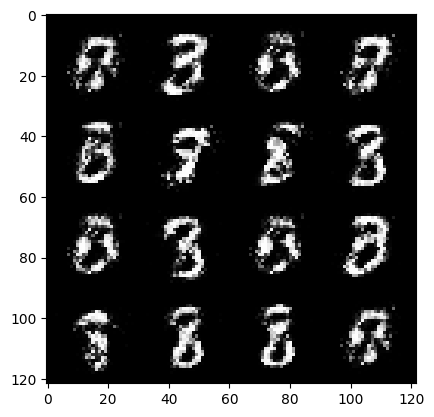

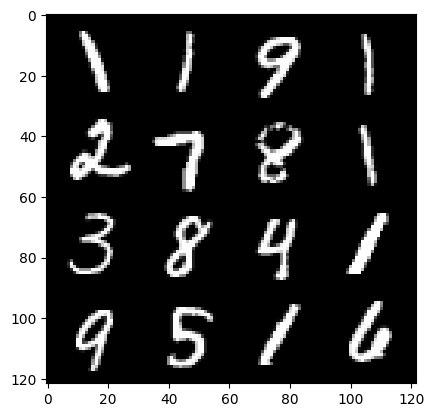

49: step 23100 / Gen loss: 6.056103189786274 / disc_loss: 0.037317079527614025


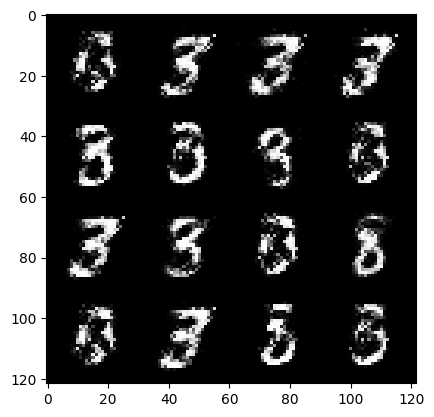

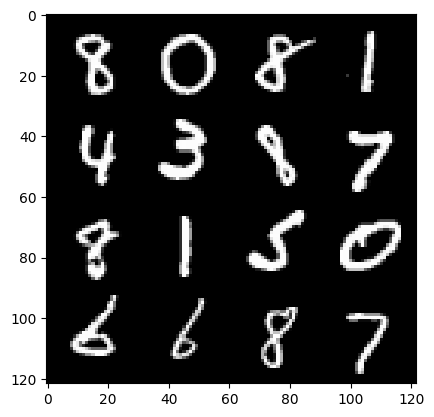

49: step 23400 / Gen loss: 5.634088567097984 / disc_loss: 0.035132320900447676


  0%|          | 0/469 [00:00<?, ?it/s]

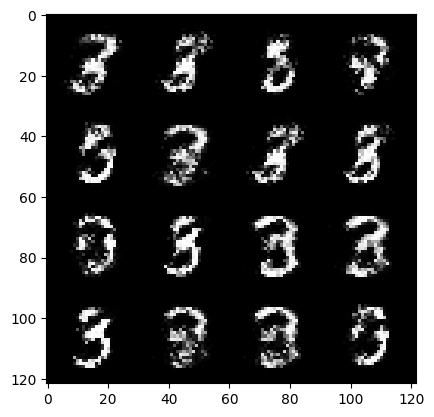

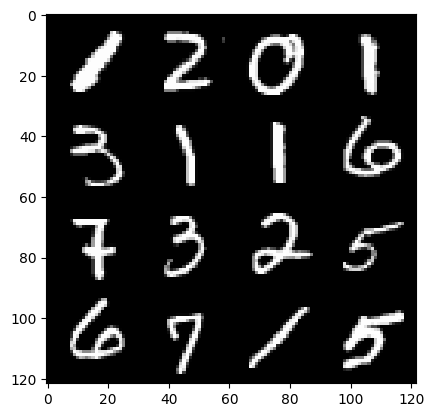

50: step 23700 / Gen loss: 5.610971967379245 / disc_loss: 0.031115939458832138


  0%|          | 0/469 [00:00<?, ?it/s]

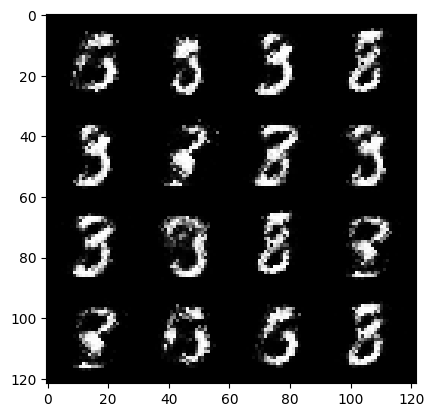

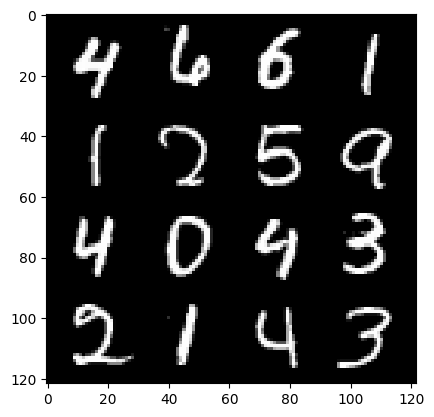

51: step 24000 / Gen loss: 6.072684728304547 / disc_loss: 0.038240285354355974


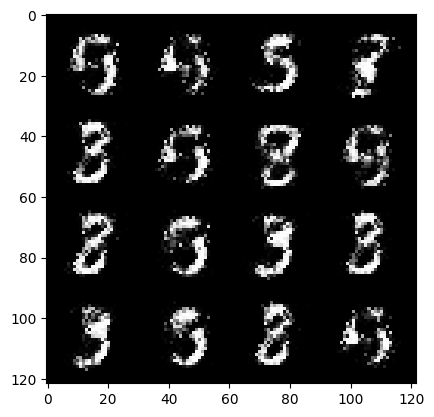

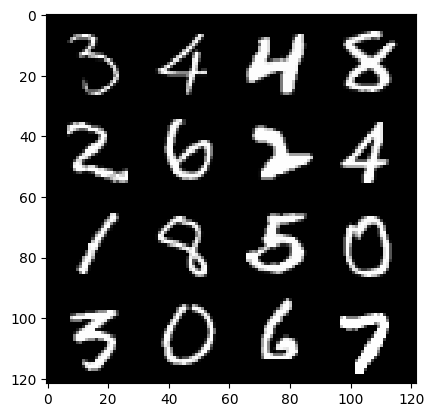

51: step 24300 / Gen loss: 5.555567522048951 / disc_loss: 0.0355807672596226


  0%|          | 0/469 [00:00<?, ?it/s]

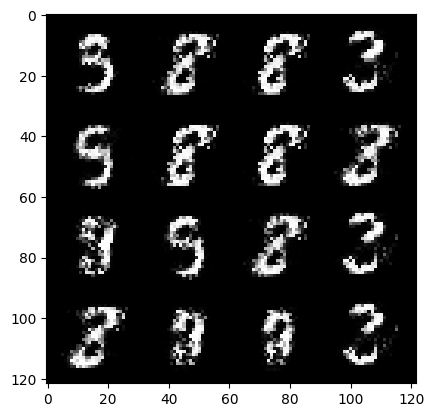

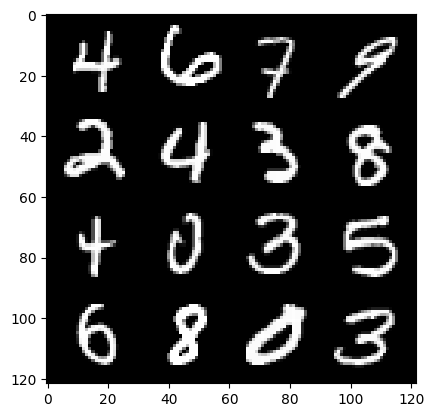

52: step 24600 / Gen loss: 6.174859655698144 / disc_loss: 0.034141764678061036


  0%|          | 0/469 [00:00<?, ?it/s]

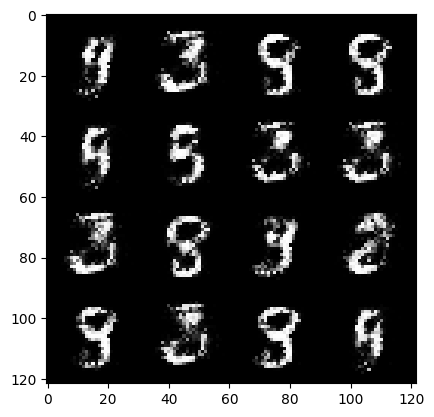

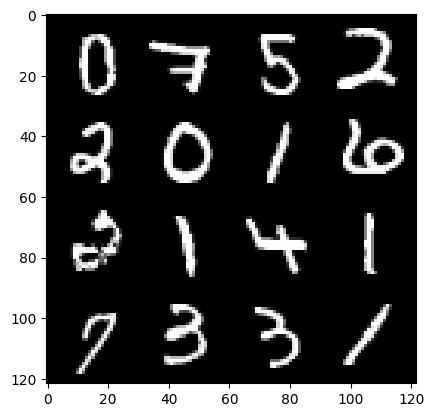

53: step 24900 / Gen loss: 5.963499712944033 / disc_loss: 0.035270599462091934


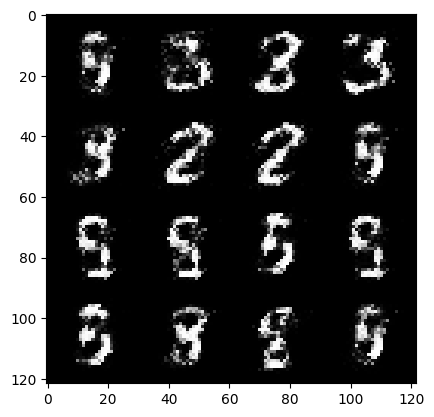

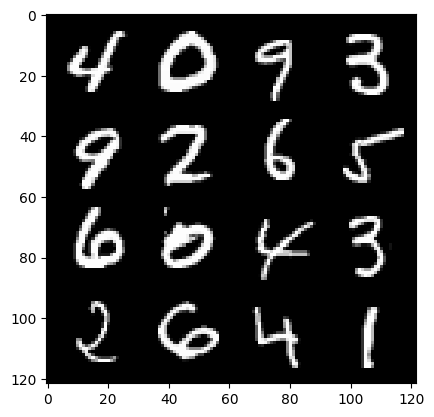

53: step 25200 / Gen loss: 5.578031492233272 / disc_loss: 0.038397239398521674


  0%|          | 0/469 [00:00<?, ?it/s]

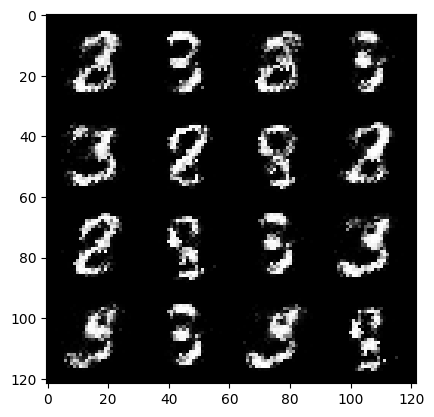

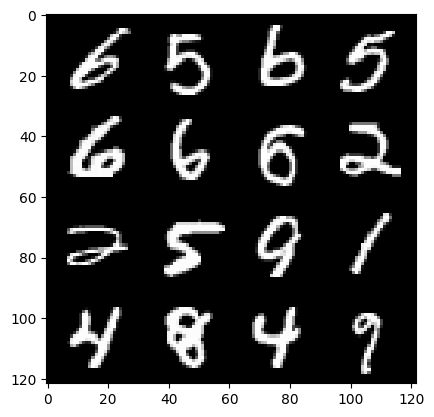

54: step 25500 / Gen loss: 5.944064399401346 / disc_loss: 0.03854178715962921


  0%|          | 0/469 [00:00<?, ?it/s]

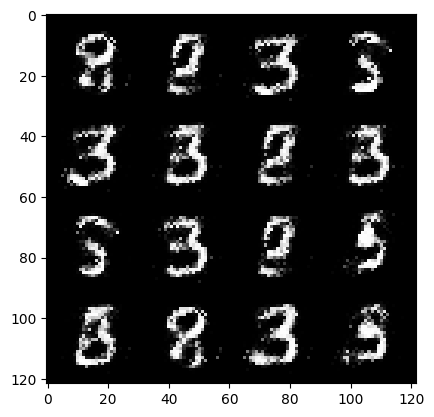

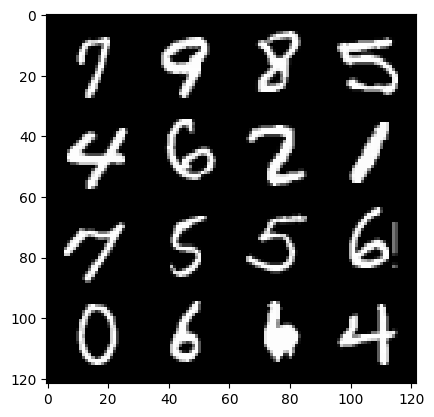

55: step 25800 / Gen loss: 6.034529687563579 / disc_loss: 0.039625552923729046


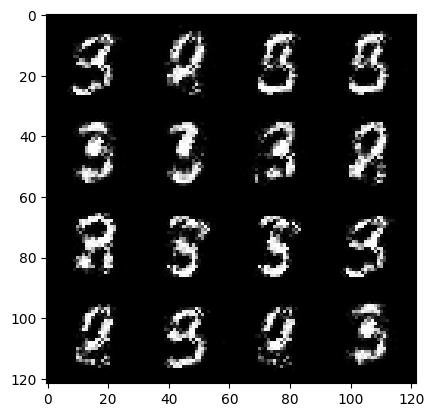

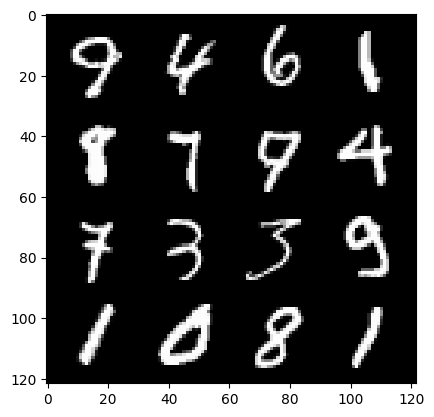

55: step 26100 / Gen loss: 5.688269912401833 / disc_loss: 0.047104380593324675


  0%|          | 0/469 [00:00<?, ?it/s]

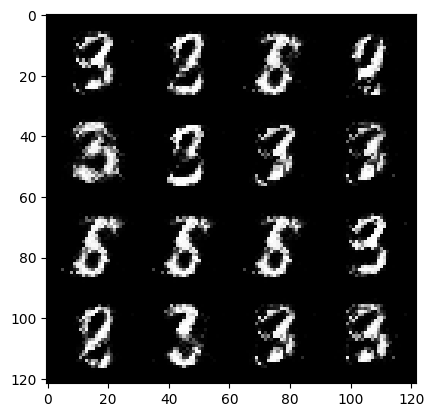

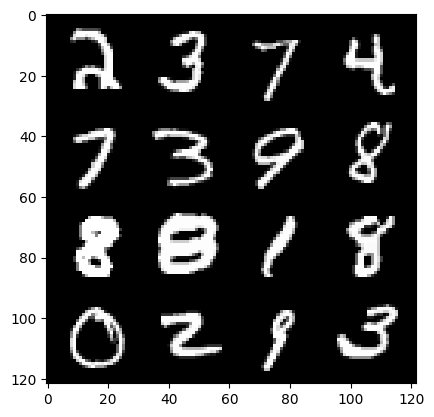

56: step 26400 / Gen loss: 5.498401020367942 / disc_loss: 0.04603840358555318


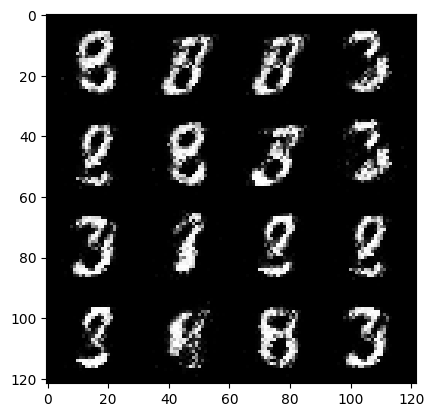

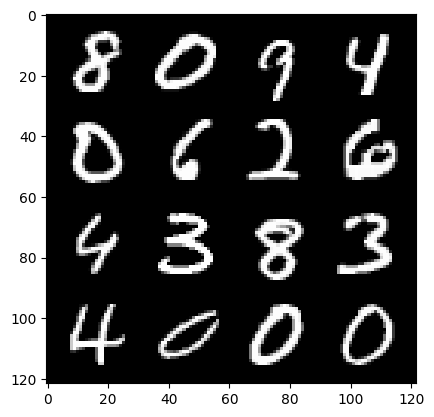

56: step 26700 / Gen loss: 5.434969549179083 / disc_loss: 0.050852689634387695


  0%|          | 0/469 [00:00<?, ?it/s]

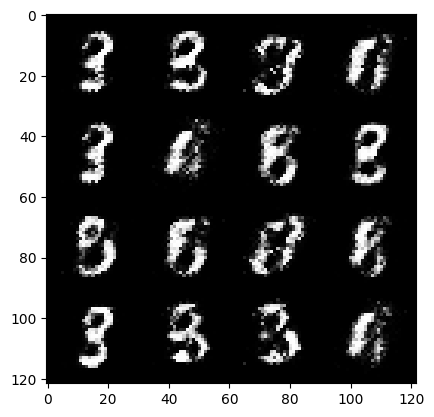

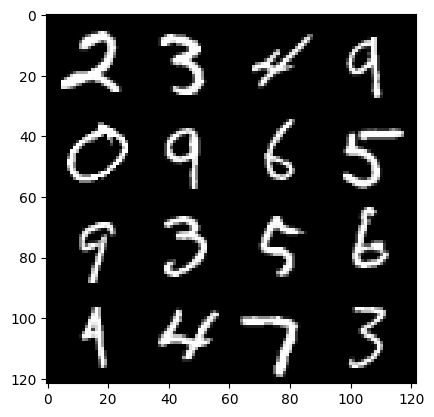

57: step 27000 / Gen loss: 5.331183872222905 / disc_loss: 0.049341751520211516


  0%|          | 0/469 [00:00<?, ?it/s]

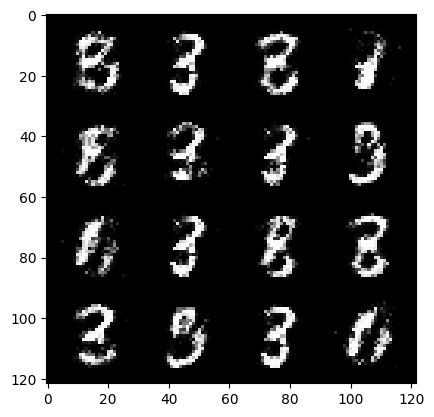

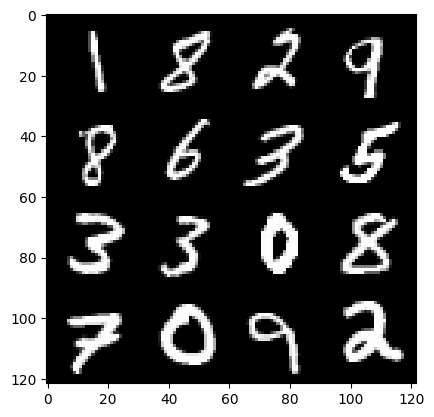

58: step 27300 / Gen loss: 5.189296038945514 / disc_loss: 0.04383953801356256


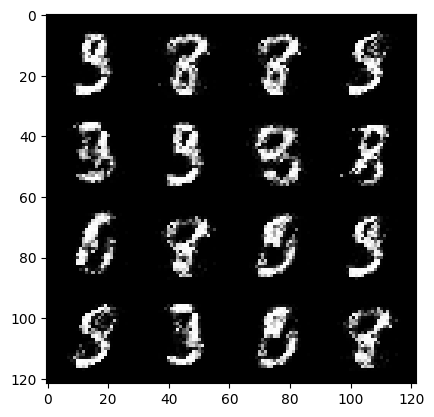

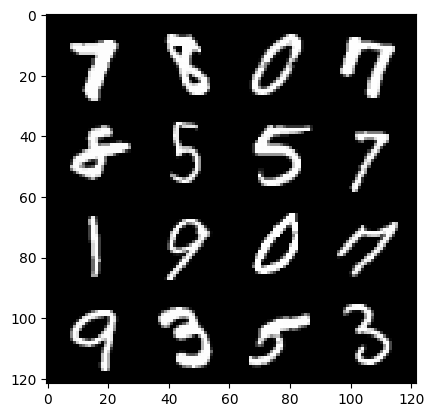

58: step 27600 / Gen loss: 5.5537542311350565 / disc_loss: 0.04076049351288624


  0%|          | 0/469 [00:00<?, ?it/s]

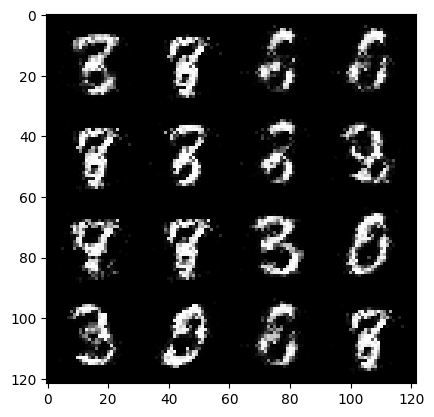

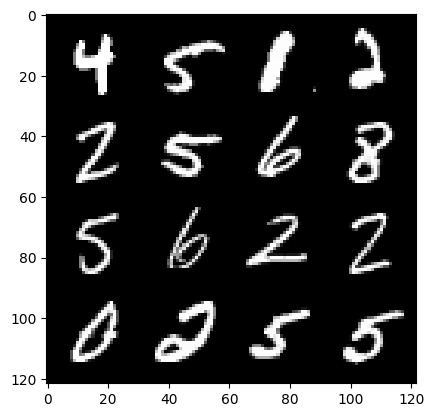

59: step 27900 / Gen loss: 5.539100327491764 / disc_loss: 0.04465500490739942


  0%|          | 0/469 [00:00<?, ?it/s]

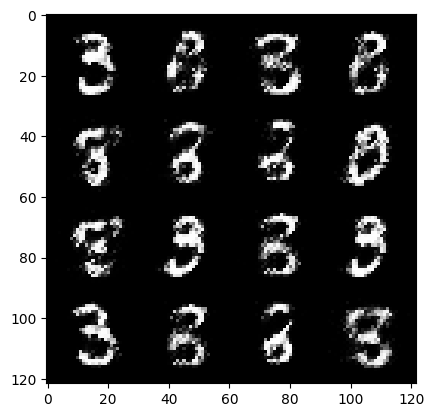

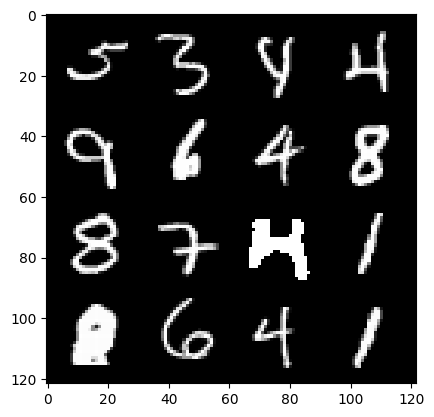

60: step 28200 / Gen loss: 5.657140927314762 / disc_loss: 0.0468563917465508


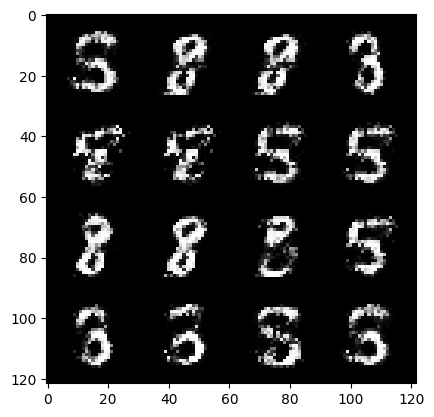

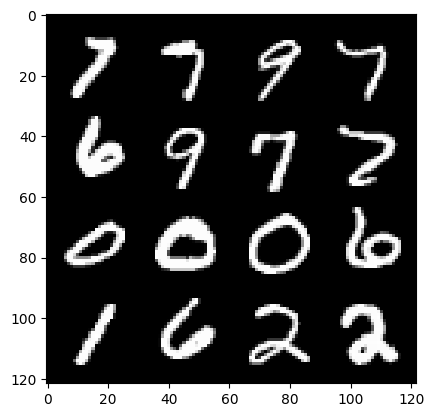

60: step 28500 / Gen loss: 5.6109081157048495 / disc_loss: 0.04494538897648452


  0%|          | 0/469 [00:00<?, ?it/s]

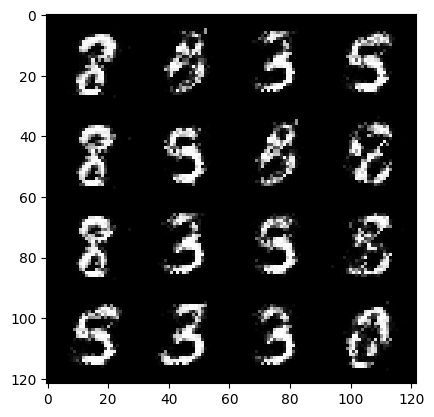

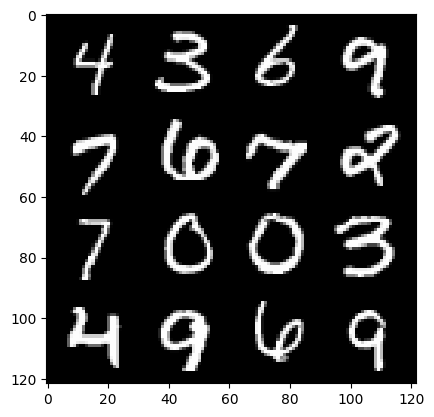

61: step 28800 / Gen loss: 5.374379772345223 / disc_loss: 0.06024649082372588


  0%|          | 0/469 [00:00<?, ?it/s]

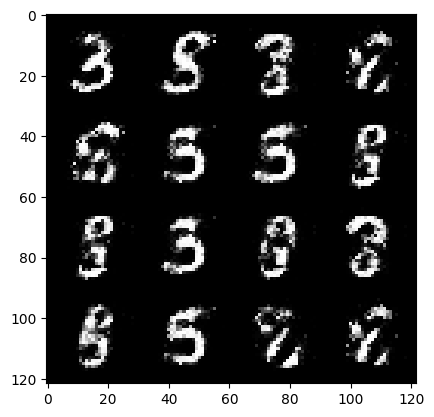

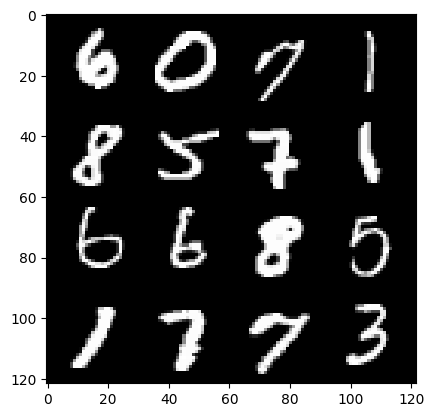

62: step 29100 / Gen loss: 5.34006744543711 / disc_loss: 0.04798415809248887


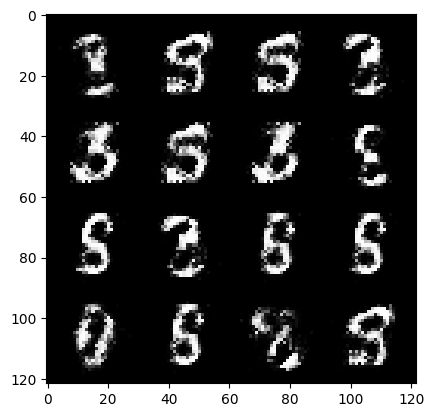

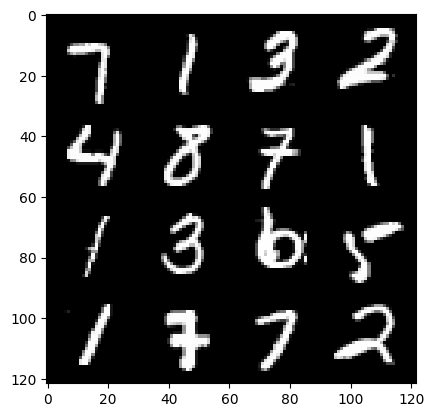

62: step 29400 / Gen loss: 5.685539105733236 / disc_loss: 0.050098257446661576


  0%|          | 0/469 [00:00<?, ?it/s]

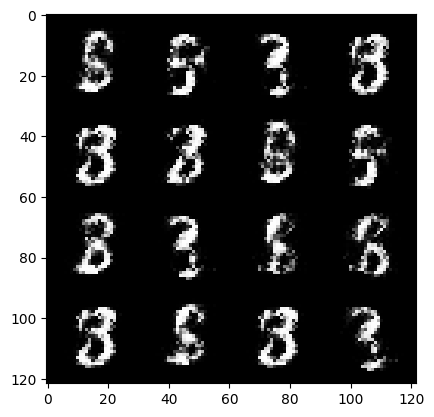

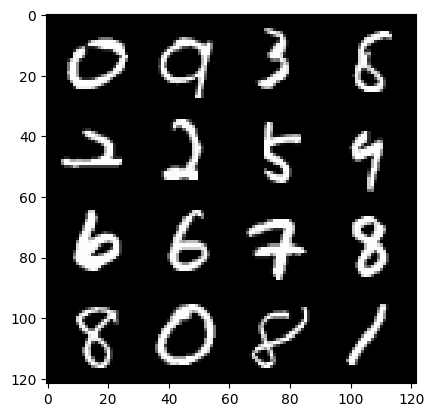

63: step 29700 / Gen loss: 5.03429888089498 / disc_loss: 0.06422606122680007


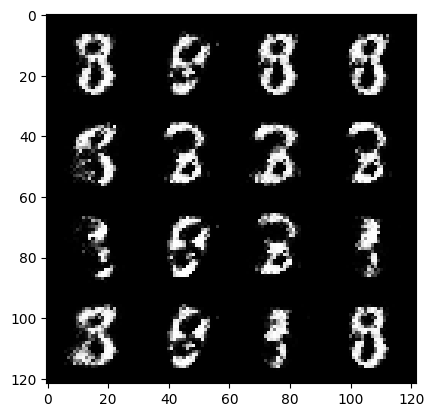

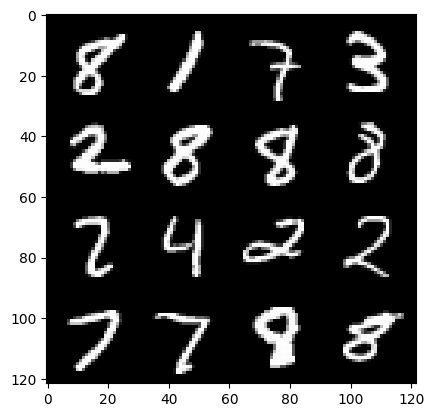

63: step 30000 / Gen loss: 5.156278698444364 / disc_loss: 0.07385726142053807


  0%|          | 0/469 [00:00<?, ?it/s]

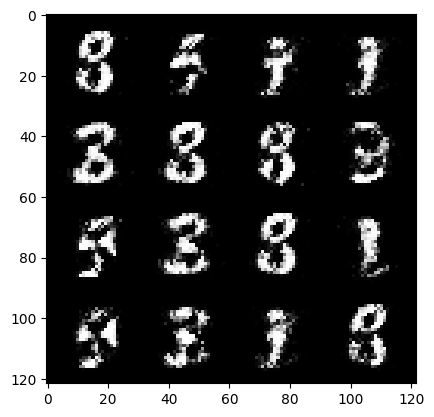

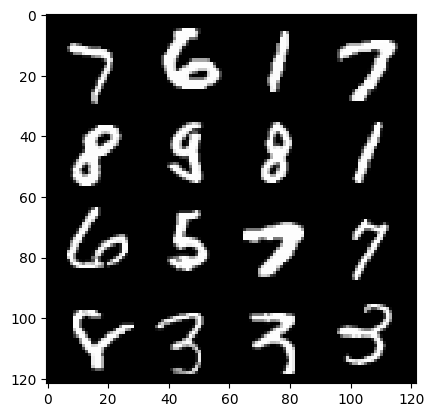

64: step 30300 / Gen loss: 4.9709331091245 / disc_loss: 0.06739089207413296


  0%|          | 0/469 [00:00<?, ?it/s]

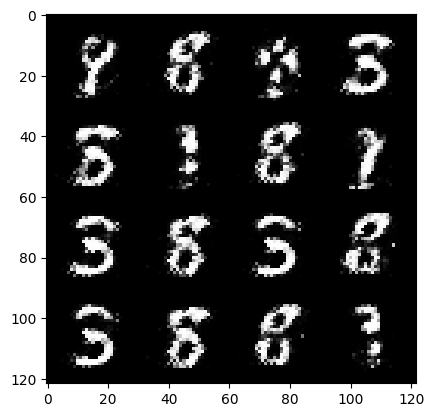

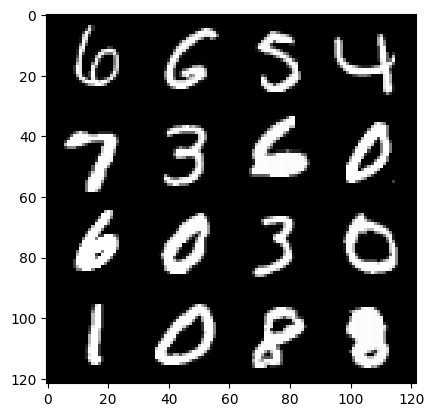

65: step 30600 / Gen loss: 5.113061833381654 / disc_loss: 0.05079859444561099


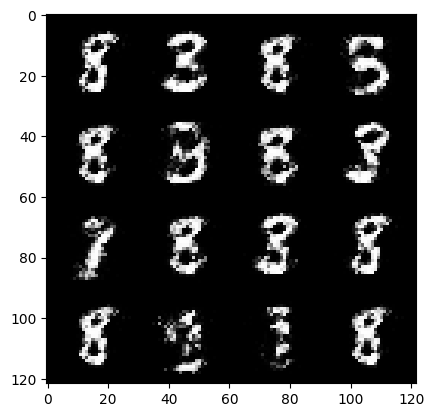

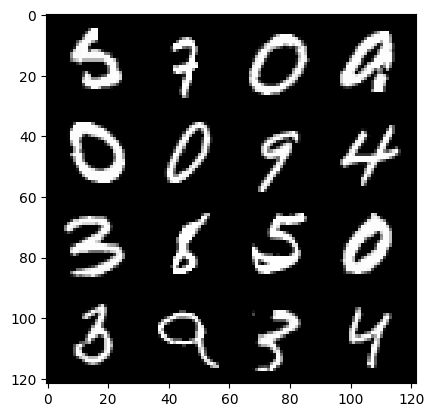

65: step 30900 / Gen loss: 5.430141921043396 / disc_loss: 0.06464687345239024


  0%|          | 0/469 [00:00<?, ?it/s]

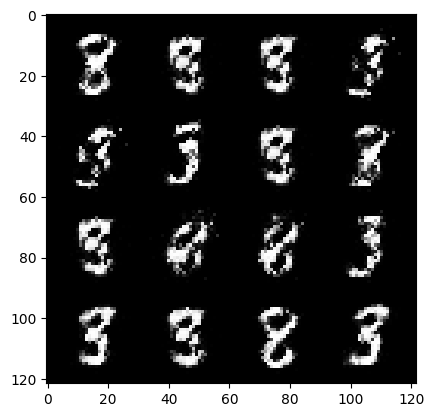

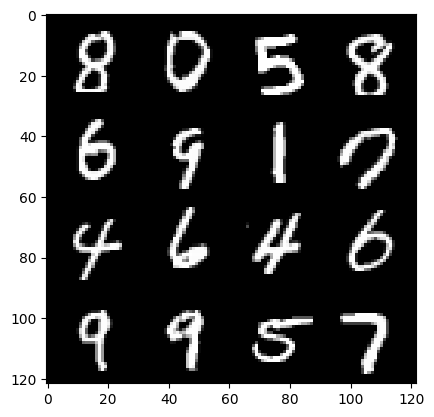

66: step 31200 / Gen loss: 4.838403430779773 / disc_loss: 0.06793893076479436


  0%|          | 0/469 [00:00<?, ?it/s]

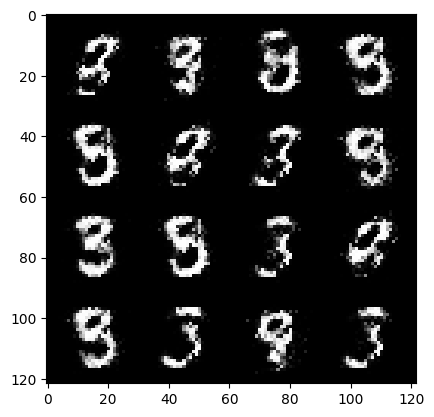

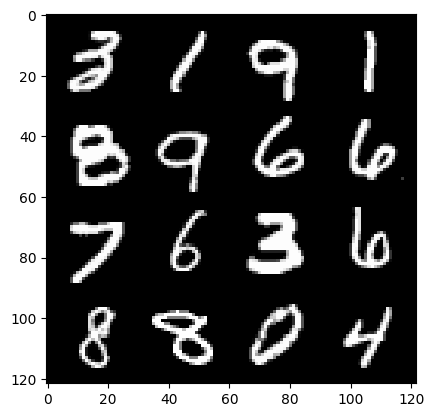

67: step 31500 / Gen loss: 4.989427634874982 / disc_loss: 0.056996203167364014


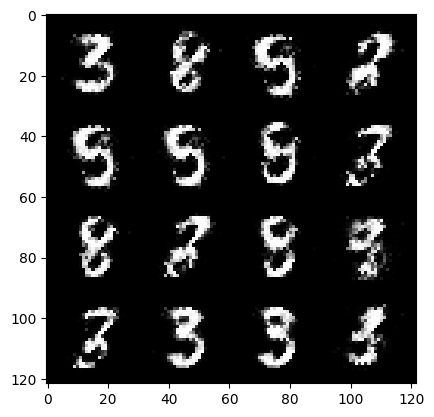

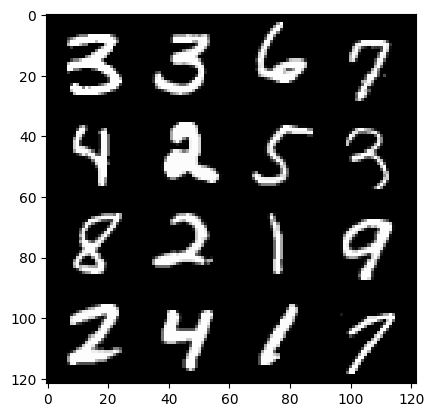

67: step 31800 / Gen loss: 5.214329392115276 / disc_loss: 0.05410301241713268


  0%|          | 0/469 [00:00<?, ?it/s]

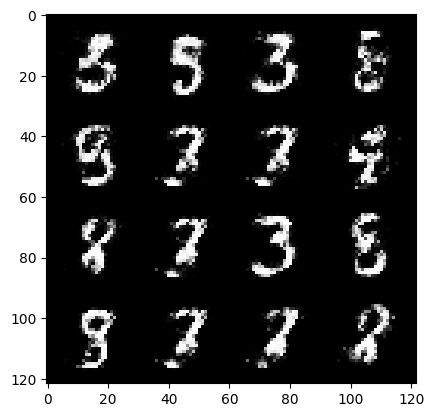

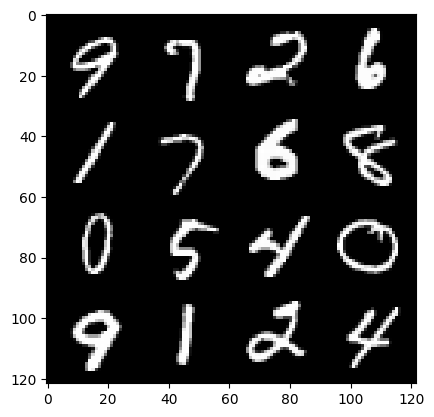

68: step 32100 / Gen loss: 4.984191855589554 / disc_loss: 0.06415147085053224


  0%|          | 0/469 [00:00<?, ?it/s]

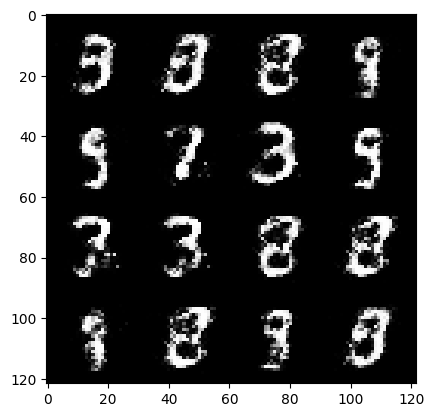

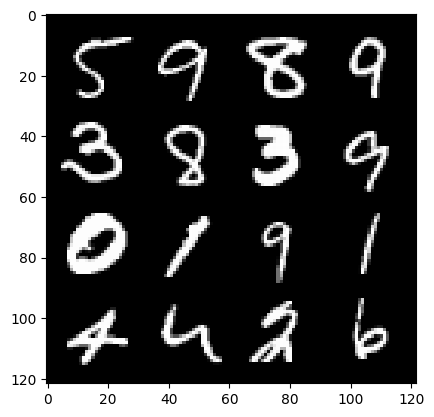

69: step 32400 / Gen loss: 4.870712864398956 / disc_loss: 0.07122375199571251


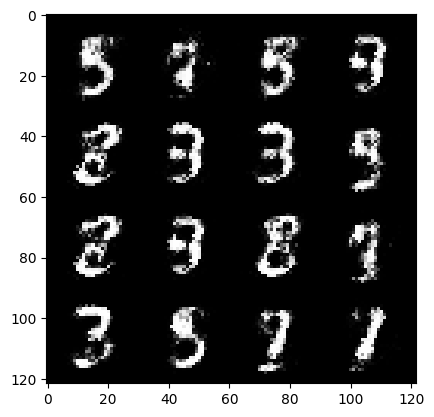

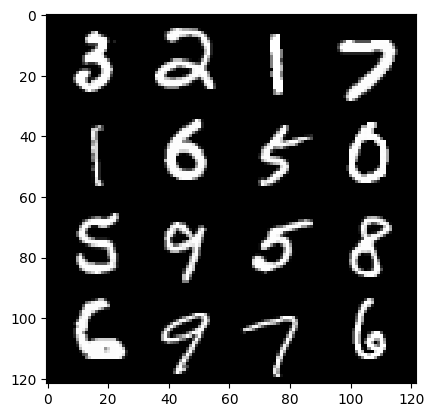

69: step 32700 / Gen loss: 5.00345410426458 / disc_loss: 0.054368256488814944


  0%|          | 0/469 [00:00<?, ?it/s]

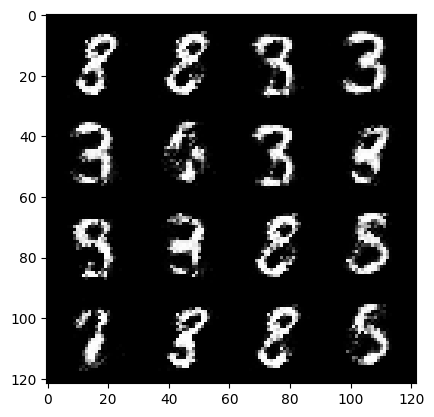

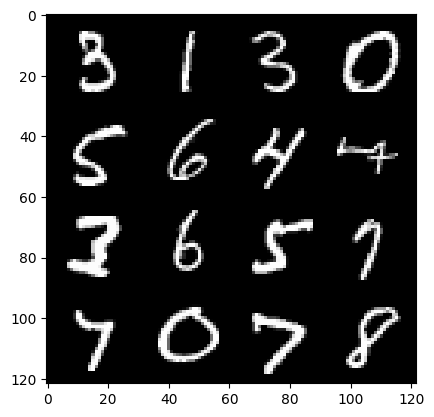

70: step 33000 / Gen loss: 5.196317197481786 / disc_loss: 0.056792097985744486


  0%|          | 0/469 [00:00<?, ?it/s]

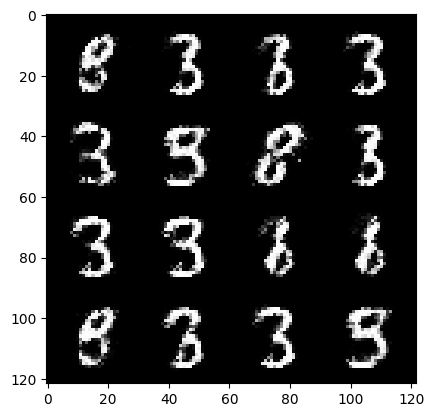

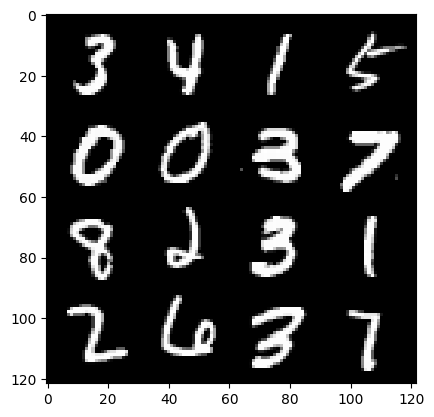

71: step 33300 / Gen loss: 5.075926419099171 / disc_loss: 0.061640696950877684


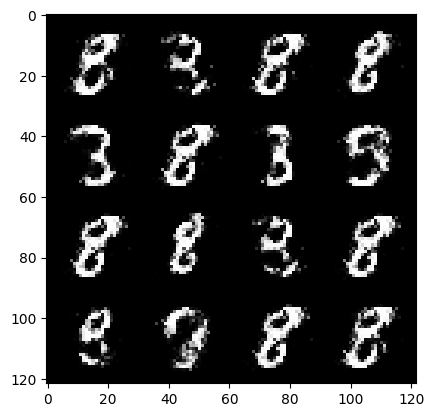

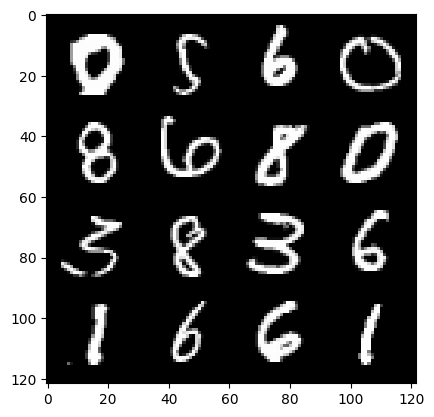

71: step 33600 / Gen loss: 5.315815957387284 / disc_loss: 0.04482892276408769


  0%|          | 0/469 [00:00<?, ?it/s]

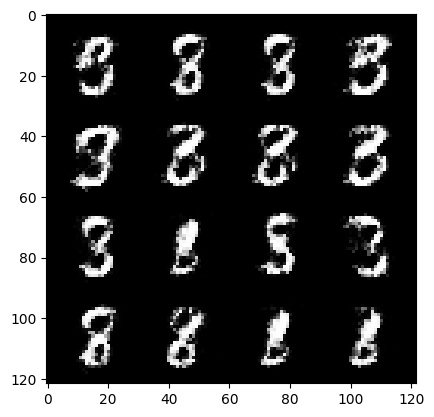

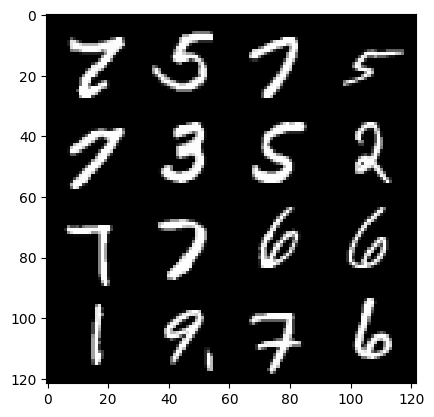

72: step 33900 / Gen loss: 5.1309625808397925 / disc_loss: 0.06272526611263554


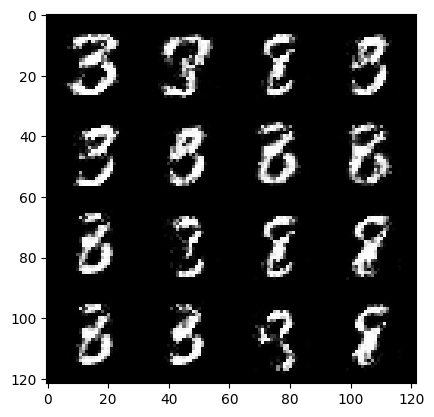

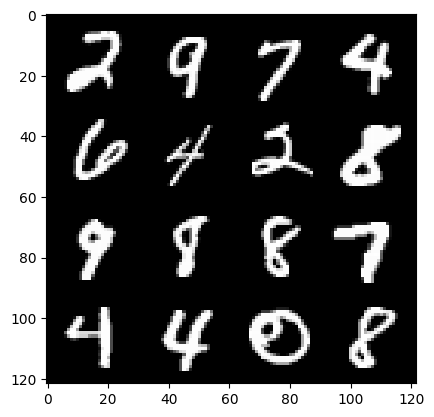

72: step 34200 / Gen loss: 4.6681904013951625 / disc_loss: 0.07295640589048465


  0%|          | 0/469 [00:00<?, ?it/s]

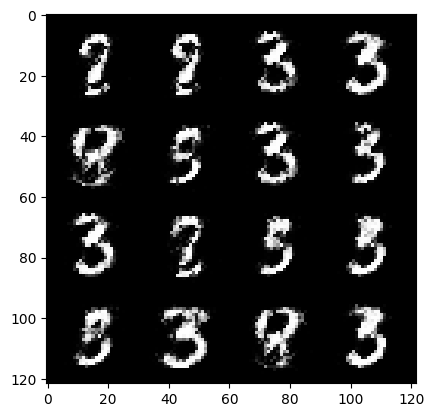

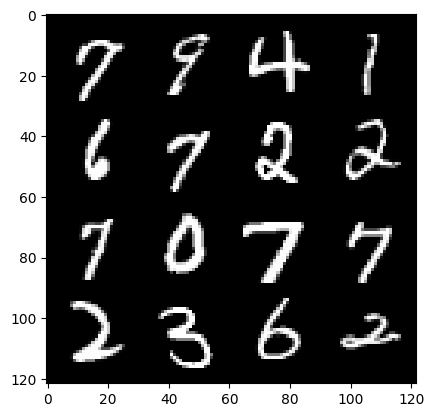

73: step 34500 / Gen loss: 4.874017727375033 / disc_loss: 0.05427801593206822


  0%|          | 0/469 [00:00<?, ?it/s]

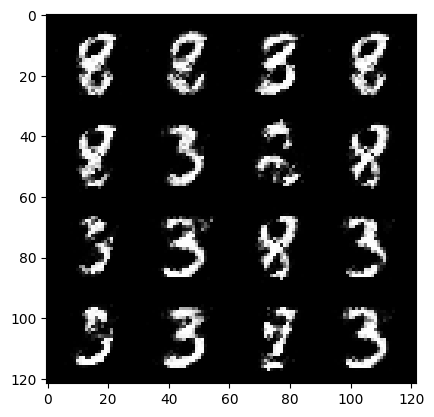

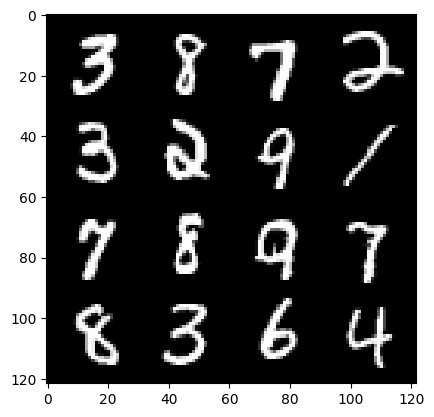

74: step 34800 / Gen loss: 5.244230646292365 / disc_loss: 0.07237657580214246


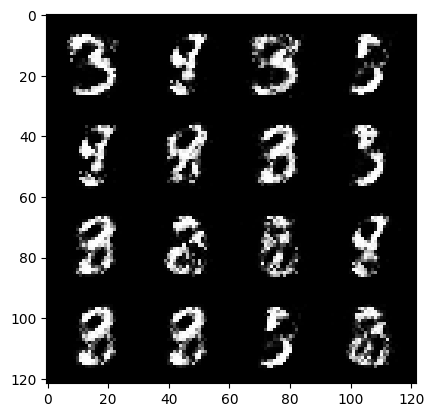

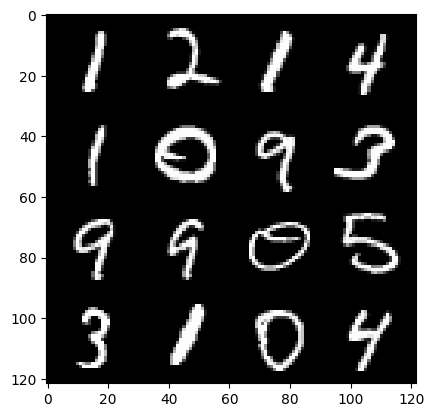

74: step 35100 / Gen loss: 4.684693048795066 / disc_loss: 0.08135651651769876


  0%|          | 0/469 [00:00<?, ?it/s]

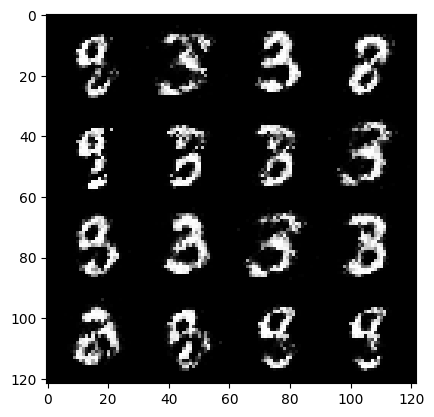

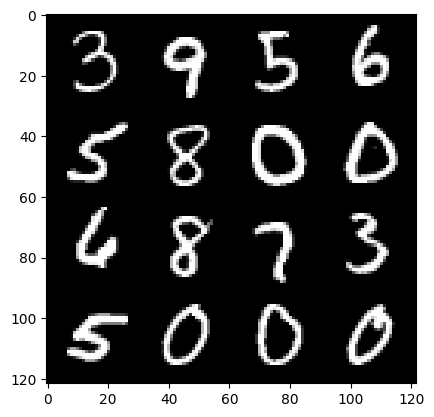

75: step 35400 / Gen loss: 4.948666932582853 / disc_loss: 0.07171281586090725


  0%|          | 0/469 [00:00<?, ?it/s]

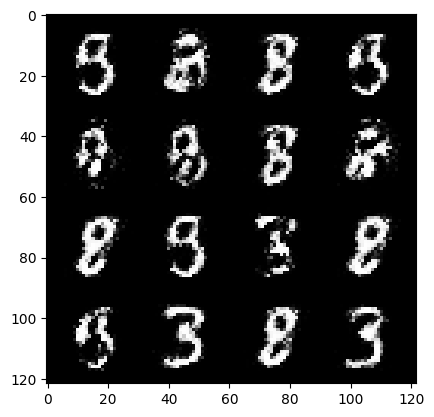

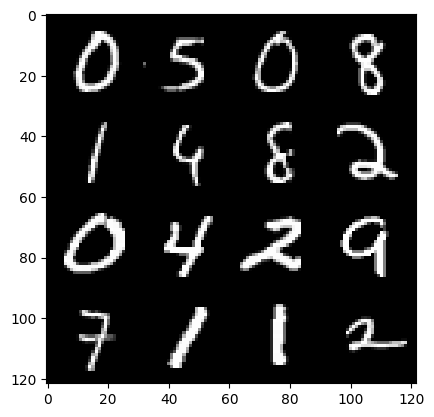

76: step 35700 / Gen loss: 4.683021868864698 / disc_loss: 0.07780129423054556


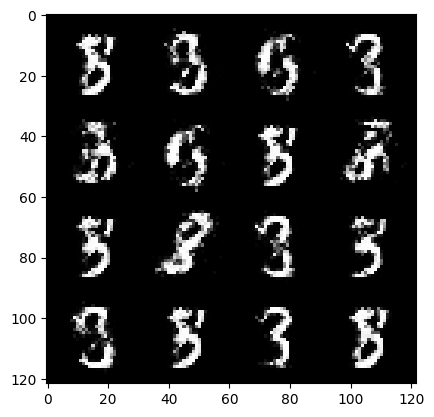

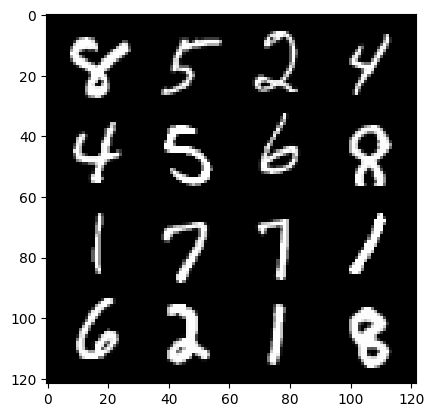

76: step 36000 / Gen loss: 4.712034892241164 / disc_loss: 0.07331115350437661


  0%|          | 0/469 [00:00<?, ?it/s]

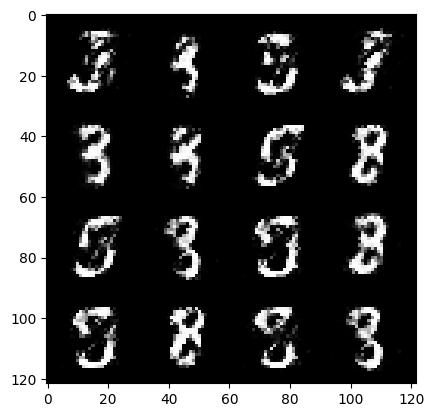

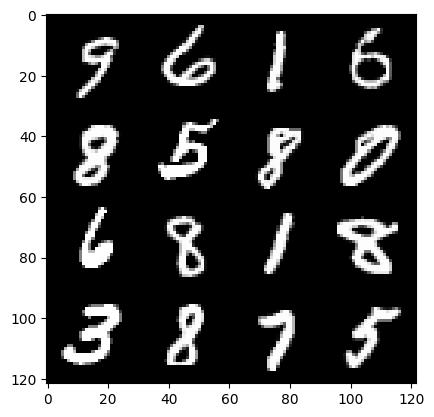

77: step 36300 / Gen loss: 4.944823805491126 / disc_loss: 0.0752030266541988


In [ ]:
### 60000 / 128 = 468.75  = 469 steps in each epoch
### Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs=len(real) # real: 128 x 1 x 28 x 28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1
